In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Load data

In [5]:
df_1min = load_pkl('../../experiments/feat_engin//data/data_shift_time_1min.pkl')
# df_5min = load_pkl('experiments/model_one_fc/data/data_shift_time_5min.pkl')
# df_1hour = load_pkl('experiments/model_one_fc/data/data_shift_time_1hour.pkl')
# df_1day = load_pkl('experiments/model_one_fc/data/data_shift_time_1day.pkl')

In [10]:
mask_train = np.array((pd.Timestamp('2023-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-12-25')))

In [12]:
#Оставим каждый
mask_freq_min = np.array(df_1min['time'].dt.minute % 5 == 0)

mask_train &= mask_freq_min
mask_valid &= mask_freq_min
mask_test &= mask_freq_min
mask_test2 &= mask_freq_min

In [14]:
mask_time = np.array((df_1min['time'].dt.time >= pd.Timestamp('11:00:00').time()) & (df_1min['time'].dt.time <= pd.Timestamp('22:00:00').time()))
# ограничение с запасом по точкам справа, да и кто после 22 торгует, а точек и так хватает

mask_train &= mask_time
mask_valid &= mask_time
mask_test &= mask_time
mask_test2 &= mask_time

mask_time.shape[0]*11/14, mask_time.sum()

(6809308.785714285, 6893354)

In [16]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(464247, 107820, 107767, 92207)

In [18]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

772041

In [20]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.6013242820005673,
 0.1396557954823643,
 0.13958714627850075,
 0.11943277623856764)

In [22]:
df_1min['target'] = (df_1min['result'] == 'WIN').astype(int)

In [24]:
df_1min.loc[mask_train, 'target'].mean(), df_1min.loc[mask_valid, 'target'].mean(), df_1min.loc[mask_test, 'target'].mean(), df_1min.loc[mask_test2, 'target'].mean()

(0.1028310360648534,
 0.1709144871081432,
 0.2071134948546401,
 0.2534297829882764)

In [31]:
# import keras

# model = keras.saving.load_model('./best_models/model_0004.keras',
#                                 custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})


# AUC_ROC:  [0.667, 0.581, 0.56, 0.588]
# PRECISION:  [0.455, 0.511, 0.461, 0.47]

# Evaluate

In [26]:
df = df_1min.copy()
df.head()

time       close   volume ticker  index_1min_start  \
index                                                                     
0     2022-10-03 10:01:00  219.929993  87793.0   GAZP               0.0   
1     2022-10-03 10:02:00  220.080002  61549.0   GAZP               0.0   
2     2022-10-03 10:03:00  219.339996  52640.0   GAZP               0.0   
3     2022-10-03 10:04:00  218.960007  61506.0   GAZP               0.0   
4     2022-10-03 10:05:00  218.300003  51464.0   GAZP               0.0   

       index_5min  index_start_5min  index_1hour  index_start_1hour  \
index                                                                 
0             NaN               NaN          NaN                NaN   
1             NaN               NaN          NaN                NaN   
2             NaN               NaN          NaN                NaN   
3             NaN               NaN          NaN                NaN   
4             0.0               0.0          NaN                NaN   

       index_1day  ...  close_w30_roc close_w30_diff volume_w30_ma  \
index              ...                                               
0             NaN  ...            NaN            NaN  87793.000000   
1             NaN  ...            NaN            NaN  74671.000000   
2             NaN  ...            NaN            NaN  67327.335938   
3             NaN  ...            NaN            NaN  65872.000000   
4             NaN  ...            NaN            NaN  62990.398438   

       volume_w30_std  volume_w30_min  volume_w30_max  volume_w30_rsi  \
index                                                                   
0                 NaN         87793.0         87793.0             NaN   
1        18557.310547         61549.0         87793.0        0.000000   
2        18274.988281         52640.0         87793.0        0.000000   
3        15202.701172         52640.0         87793.0       20.141302   
4        14658.092773         51464.0         87793.0       16.399992   

       volume_w30_roc  volume_w30_diff  target  
index                                           
0                 NaN              NaN       0  
1                 NaN              NaN       0  
2                 NaN              NaN       0  
3                 NaN              NaN       0  
4                 NaN              NaN       0  

[5 rows x 48 columns]

In [28]:
df['sample'] = None
df.loc[mask_valid, 'sample'] = 'valid'
df.loc[mask_test, 'sample'] = 'test'
df.loc[mask_test2, 'sample'] = 'test2'

### load data

In [30]:
#load data

y_pred_valid = load_pkl('./y_pred_valid.pkl')
y_pred_test = load_pkl('./y_pred_test.pkl')
y_pred_test2 = load_pkl('./y_pred_test2.pkl')


df['y_pred'] = None
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

In [32]:
mask = np.array(df['y_pred'].notnull())
df = df[mask]
df.reset_index(inplace=True)

mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

### auc_roc

In [38]:
#(0.5704016189995371, 0.5950226604609953, 0.5873542303281121) - old

In [40]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.7119767785797009, 0.6969947847631388, 0.6496127742886606)

### target

In [235]:
q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('Valid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('Test')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('Test2')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))

Valid
result
WIN     0.457831
LOSE    0.436515
DNF     0.105653
Name: proportion, dtype: float64
Test
result
WIN     0.490724
LOSE    0.440631
DNF     0.068646
Name: proportion, dtype: float64
Test2
result
WIN     0.513078
LOSE    0.428571
DNF     0.058350
Name: proportion, dtype: float64


In [249]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print('Valid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("Test")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('Tetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))

threshokd = 0.5035864776372909
Valid
result
WIN     0.457831
LOSE    0.436515
DNF     0.105653
Name: proportion, dtype: float64
Test
result
WIN     0.462687
LOSE    0.453289
DNF     0.084024
Name: proportion, dtype: float64
Tetst2
result
WIN     0.490104
LOSE    0.434689
DNF     0.075207
Name: proportion, dtype: float64


In [253]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1079, 1809, 2779)

In [75]:
df

index                time       close   volume ticker  \
0        364705 2024-07-01 11:00:00  116.260002   1842.0   GAZP   
1        364710 2024-07-01 11:05:00  116.239998   1691.0   GAZP   
2        364715 2024-07-01 11:10:00  116.470001   6948.0   GAZP   
3        364720 2024-07-01 11:15:00  116.400002    526.0   GAZP   
4        364725 2024-07-01 11:20:00  116.870003  12467.0   GAZP   
...         ...                 ...         ...      ...    ...   
307789  8665475 2024-12-24 21:40:00   32.365002      7.0   RUAL   
307790  8665480 2024-12-24 21:45:00   32.365002      4.0   RUAL   
307791  8665485 2024-12-24 21:50:00   32.375000   1134.0   RUAL   
307792  8665490 2024-12-24 21:55:00   32.369999     18.0   RUAL   
307793  8665495 2024-12-24 22:00:00   32.369999   1363.0   RUAL   

        index_1min_start  index_5min  index_start_5min  index_1hour  \
0                    0.0     73348.0               0.0       6301.0   
1                    0.0     73349.0               0.0       6301.0   
2                    0.0     73350.0               0.0       6301.0   
3                    0.0     73351.0               0.0       6301.0   
4                    0.0     73352.0               0.0       6301.0   
...                  ...         ...               ...          ...   
307789         8208890.0   1777641.0         1683710.0     152872.0   
307790         8208890.0   1777642.0         1683710.0     152872.0   
307791         8208890.0   1777643.0         1683710.0     152872.0   
307792         8208890.0   1777644.0         1683710.0     152872.0   
307793         8208890.0   1777645.0         1683710.0     152873.0   

        index_start_1hour  ...  volume_w30_ma  volume_w30_std volume_w30_min  \
0                     0.0  ...    5739.033203     6315.161133          473.0   
1                     0.0  ...    4817.916504     5863.303711          252.0   
2                     0.0  ...    4331.483398     5521.838867          252.0   
3                     0.0  ...    4371.700195     5895.754395          252.0   
4                     0.0  ...    4129.883301     5123.477051          252.0   
...                   ...  ...            ...             ...            ...   
307789           144800.0  ...     857.933350     1893.059204            1.0   
307790           144800.0  ...     832.950012     1888.485352            1.0   
307791           144800.0  ...     844.400024     2008.298096            1.0   
307792           144800.0  ...     840.983337     2008.125977            1.0   
307793           144800.0  ...     705.049988     1722.262451            1.0   

       volume_w30_max  volume_w30_rsi  volume_w30_roc  volume_w30_diff  \
0             34444.0       49.059147       -0.719763          -4731.0   
1             34444.0       47.112072       -0.877588         -12123.0   
2             34444.0       50.762016        0.777437           3039.0   
3             34444.0       48.804836       -0.906671          -5110.0   
4             27905.0       51.797340        1.419837           7315.0   
...               ...             ...             ...              ...   
307789         8784.0       50.001144        0.400000              2.0   
307790         8784.0       49.932384       -0.966387           -115.0   
307791         8784.0       50.547768        4.968421            944.0   
307792         8784.0       49.975151       -0.704918            -43.0   
307793         8032.0       50.781071        3.992674           1090.0   

        target  sample    y_pred  
0            1   valid   0.17328  
1            1   valid  0.142719  
2            1   valid  0.115586  
3            1   valid  0.105981  
4            0   valid  0.122243  
...        ...     ...       ...  
307789       0   test2  0.079166  
307790       0   test2  0.100649  
307791       0   test2  0.097427  
307792       0   test2  0.092306  
307793       0   test2  0.126671  

[307794 rows x 51 columns]

### Посомтрим на вероятности

In [80]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.7119767785797009, 0.6969947847631388, 0.6496127742886606)

290518 OZON
31


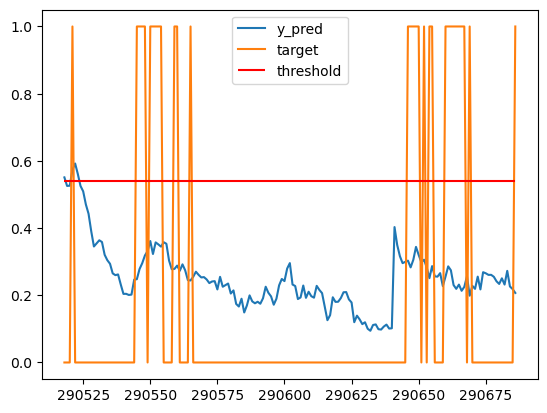

152592 NLMK
70


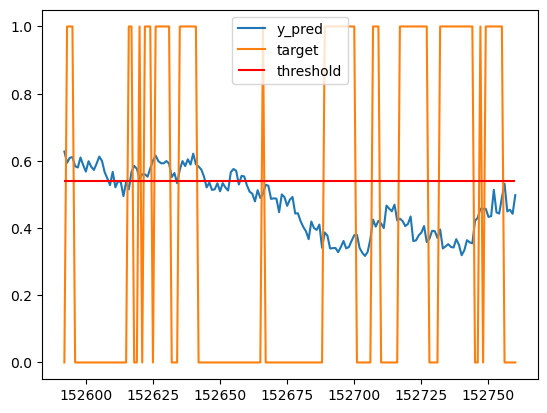

275014 T
44


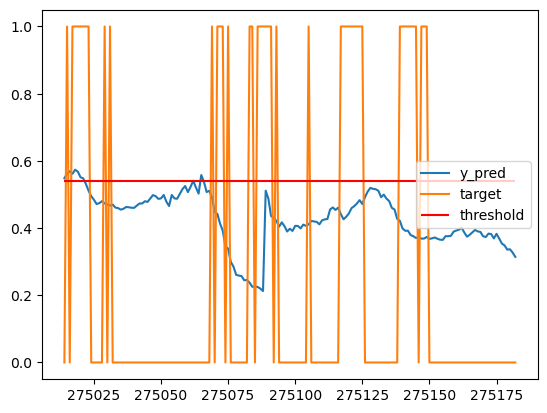

272672 T
77


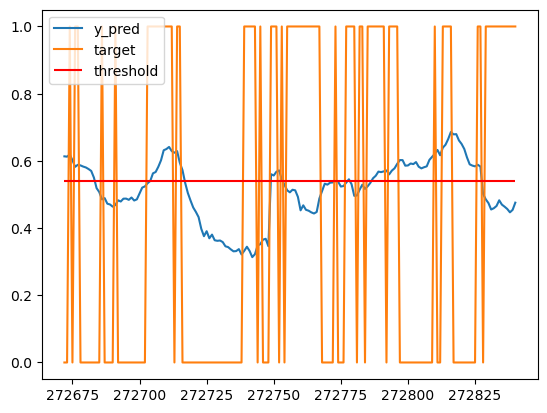

152887 NLMK
74


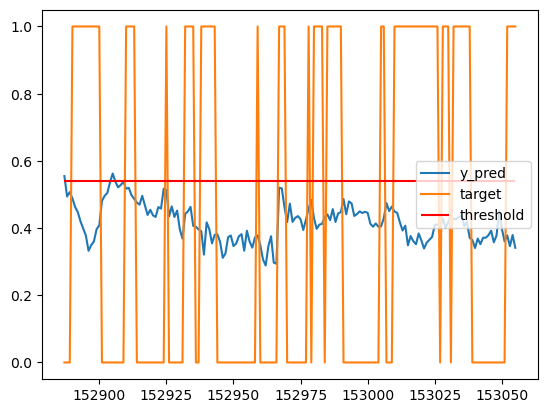

289099 OZON
94


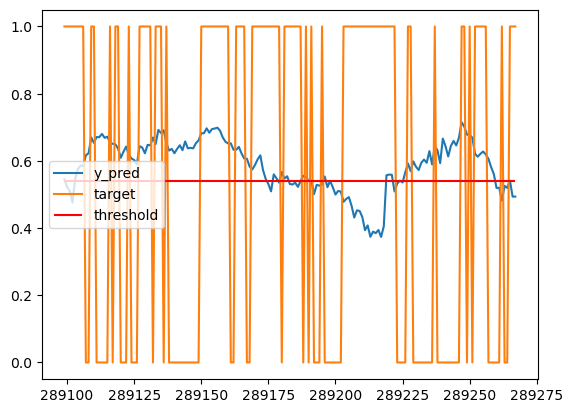

211643 ALRS
51


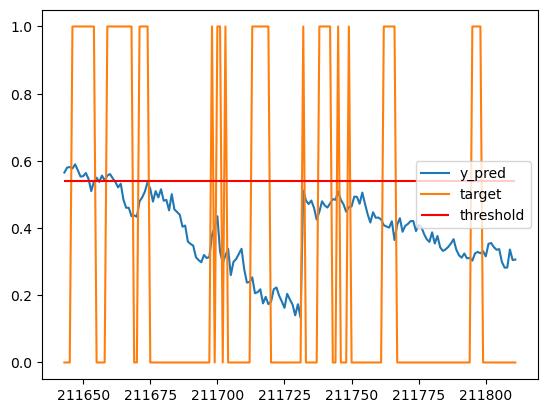

282167 OZON
80


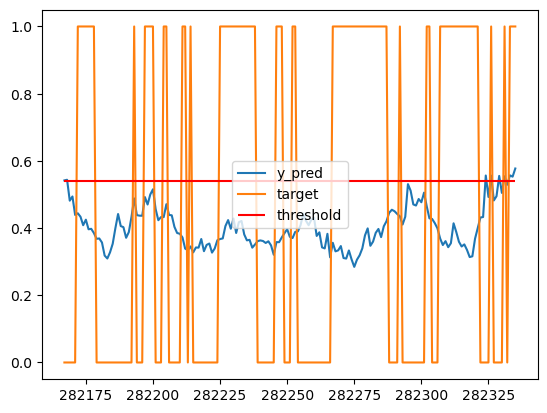

307502 RUAL
53


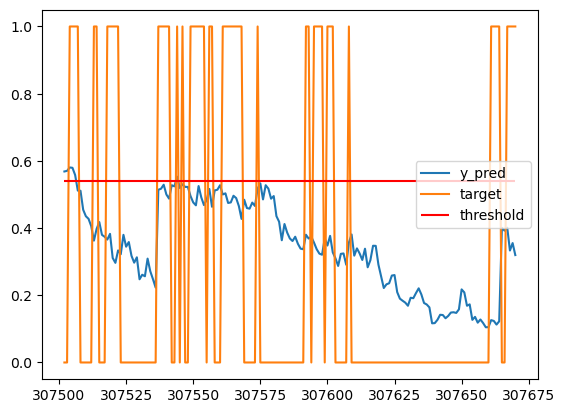

248529 MAGN
89


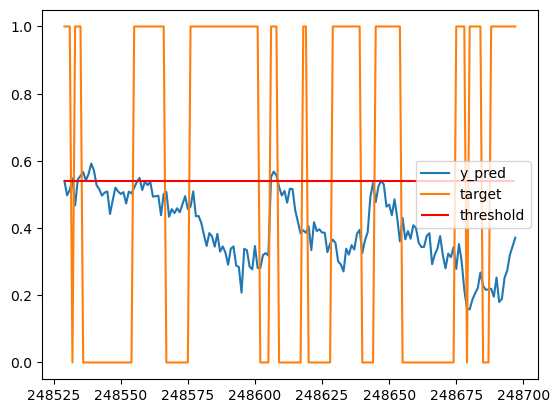

289318 OZON
66


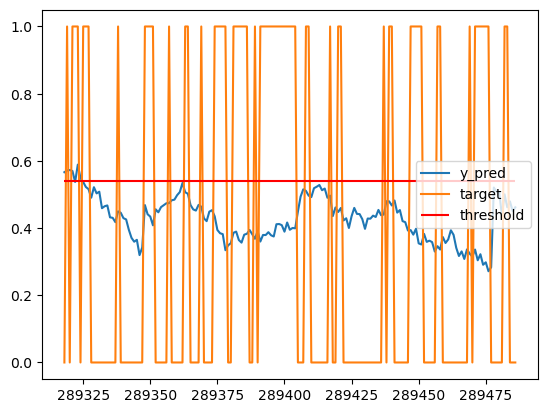

269869 T
19


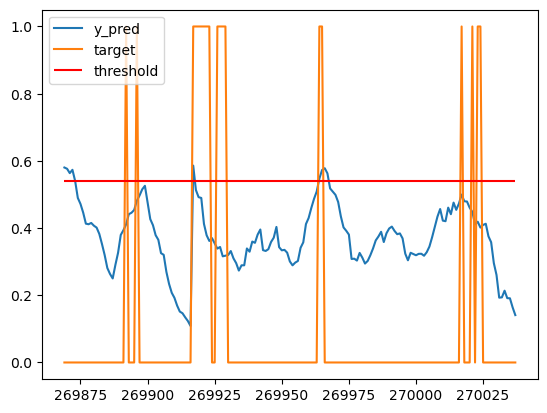

129840 GMKN
63


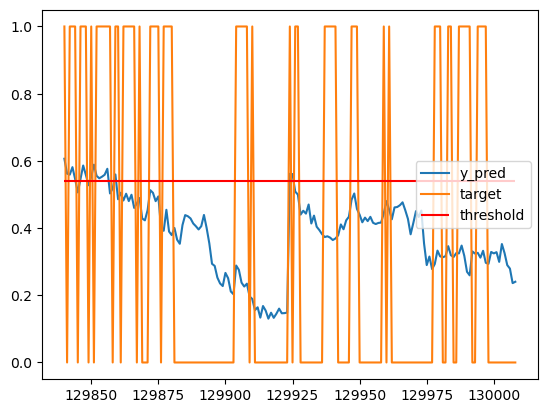

162720 NLMK
62


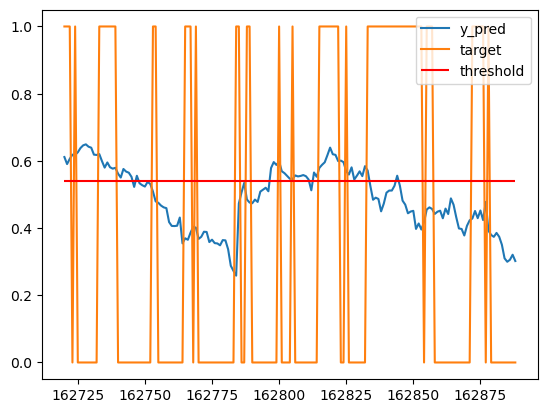

174140 TATN
56


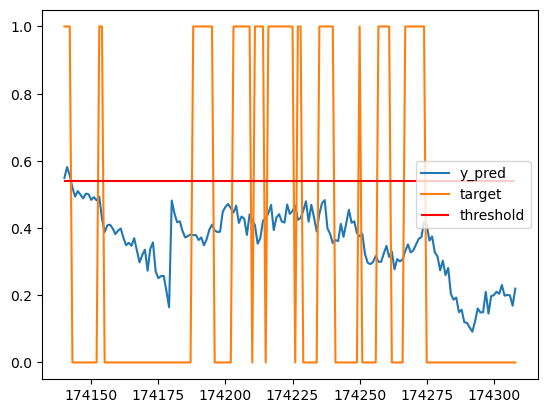

276426 OZON
89


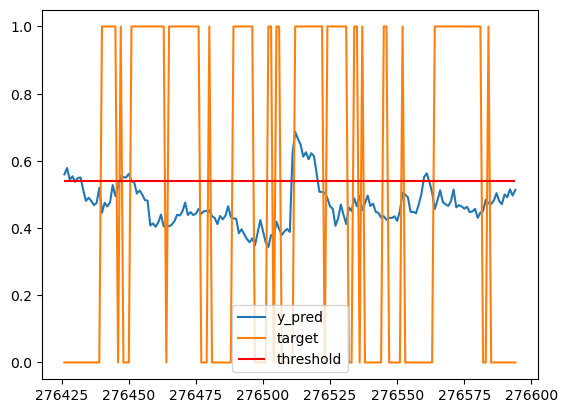

232299 CHMF
85


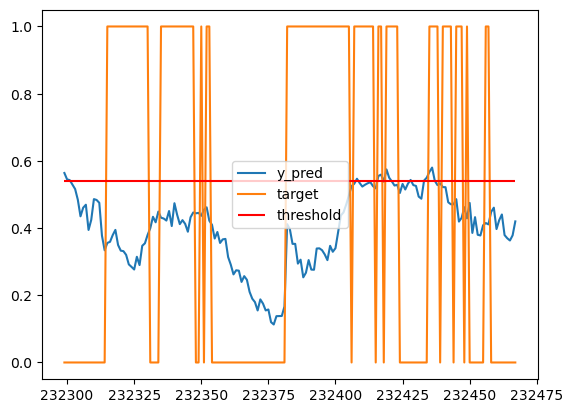

288954 OZON
74


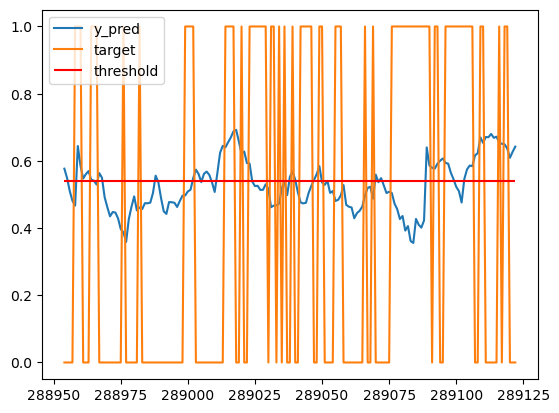

223529 YDEX
76


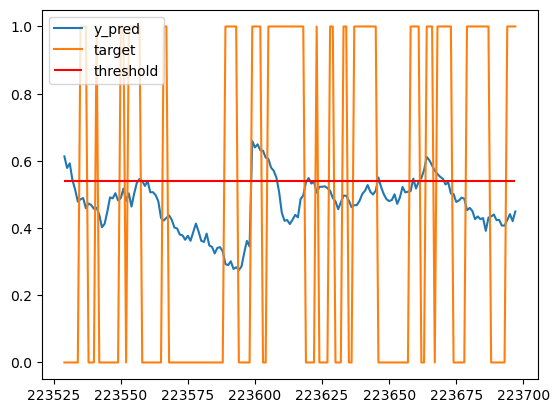

296653 RUAL
80


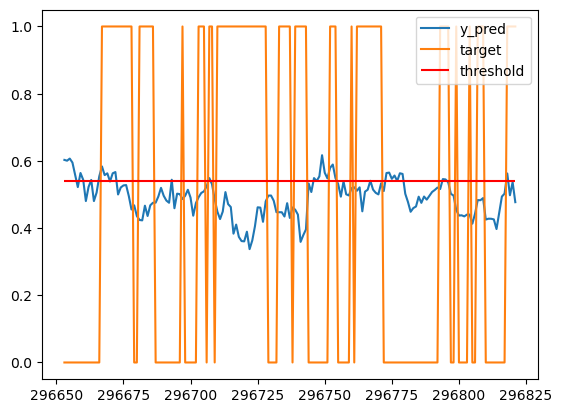

In [85]:
#bit threshold
mask = df['y_pred'] > threshold
inds = np.random.choice(df.index[(mask_valid|mask_test|mask_test2) & (mask)], size=20)



window = 12*14#день
for i in inds:
    print(i, df.loc[i, 'ticker'])
    print(df.loc[i:i+window, 'target'].sum())
    plt.plot(df.loc[i:i+window, 'y_pred'], label='y_pred')
    plt.plot(df.loc[i:i+window, 'target'], label='target')
    plt.hlines(threshold, i, i+window, color='red', label='threshold')
    plt.legend()
    plt.show()

### target24

In [92]:
# df

In [94]:
# df['result'].value_counts(normalize=True)

In [96]:
# df_result = load_pkl('./experiments/model_one_fc/df_result_wait_1day.pkl')
# df_result

In [98]:
# df_result['delta_time'] = df_result['delta_time'].replace(-1, pd.Timedelta('100 days'))
# mask = df_result['delta_time'] > pd.Timedelta('24 hours')
# df_result.loc[mask, 'result'] = 'DNF'

In [100]:
# df_result['result'].value_counts(normalize=True)

In [102]:
# df['target24'] = (df_result['result'] == 'WIN').astype(int)

In [105]:
# threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_valid&mask, 'target24'].mean())

# threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_test&mask, 'target24'].mean())

# threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_test2&mask, 'target24'].mean())

### Распределение вероятностей в целом

In [110]:
import warnings
warnings.filterwarnings('ignore')


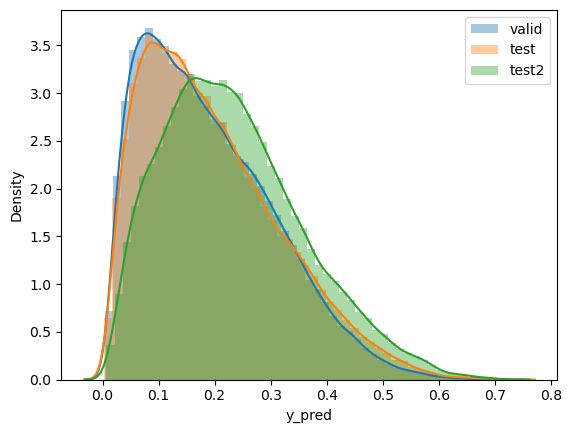

In [112]:

sns.distplot(df.loc[mask_valid, 'y_pred'], label='valid')
sns.distplot(df.loc[mask_test, 'y_pred'], label='test')
sns.distplot(df.loc[mask_test2, 'y_pred'], label='test2')
plt.legend()

In [114]:
#не так уж и плохо, есть надежды

### Распределение успеха (target) по бинам

[0.465  0.5036]


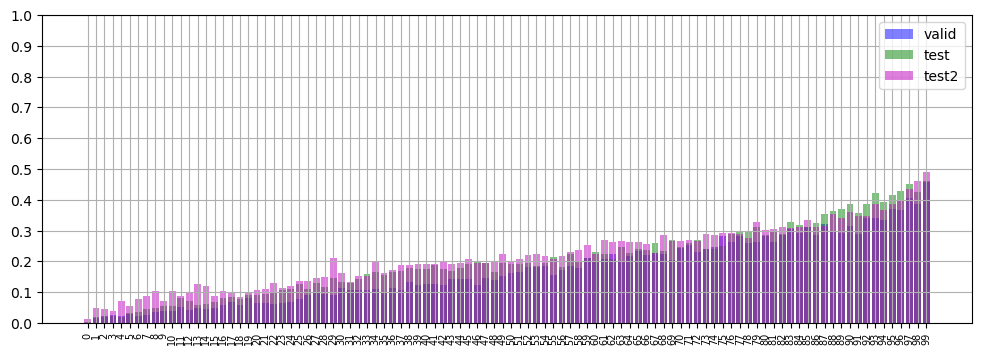

In [118]:
col_target = 'target'
q_count = 100



mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
#df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
#df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
#df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

#print
plt.figure(figsize=(12,4))
df_tmp = df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)

df_tmp = df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)

df_tmp = df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
plt.grid(visible=0.0001)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(q_count), rotation=90, size=7)
plt.legend()
plt.show()


### Распределени успеха(target24) по бинам

In [123]:
# col_target = 'target24'
# q_count = 50

# print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

# df['bin'] = None

# df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
# q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
# df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


# df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
# df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


# df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
# df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

# plt.legend()
# plt.show()

In [125]:
pd.DataFrame(np.array([np.quantile(df.loc[mask_valid, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test2, 'y_pred'], q=np.arange(0.95, 1, 0.01))
                       
                      ]).T)

0         1         2
0   0.40686  0.430098  0.467259
1   0.42233  0.446601  0.483594
2   0.44139  0.467223  0.503959
3  0.464999  0.493585  0.529759
4  0.503586  0.531677  0.568047
5  0.717447  0.734875  0.723284

In [127]:
#как-то через чур хорошо

### В разрезе тикеров (внутри каждого тикера своя вероятность)

In [138]:
def distplot(df, col_target=None, q_count=None):
    for ticker in df['ticker'].unique():
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'

        print(np.round(np.quantile(df_tk.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
        
        sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
        sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
        sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
        plt.legend()
        plt.show()



        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, labels=False)
        q = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
        #df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)
        
        plt.figure(figsize=(12,4))

        df_tmp = df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)
        
        df_tmp = df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)
        
        df_tmp = df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
        plt.grid(visible=0.0001)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xticks(np.arange(q_count), rotation=90, size=7)
        plt.legend()
        plt.show()
        

### таргет

[0.4387 0.4732]


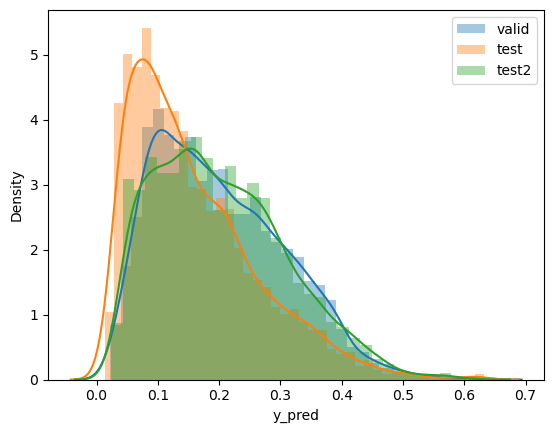

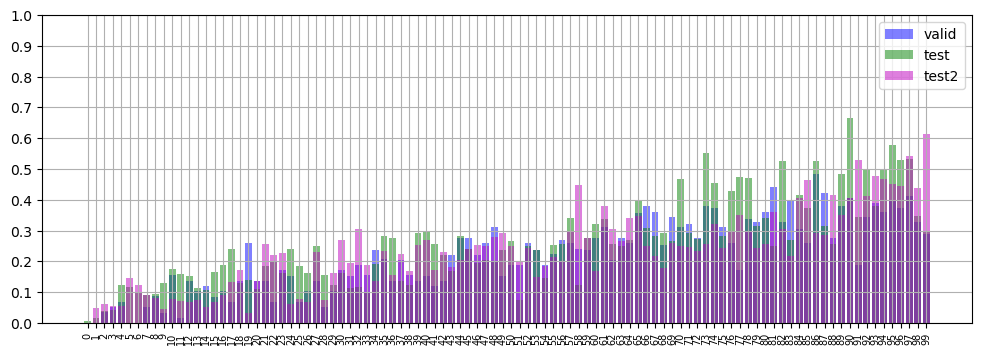

[0.3109 0.3407]


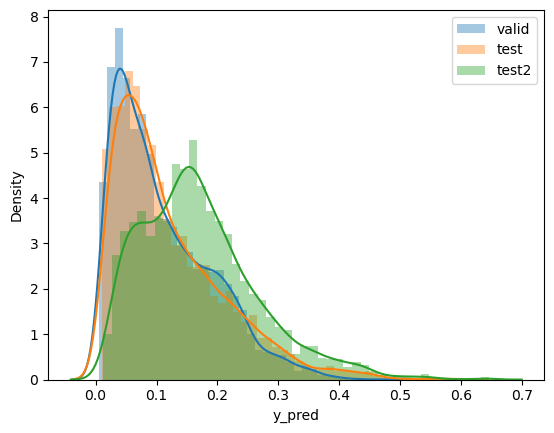

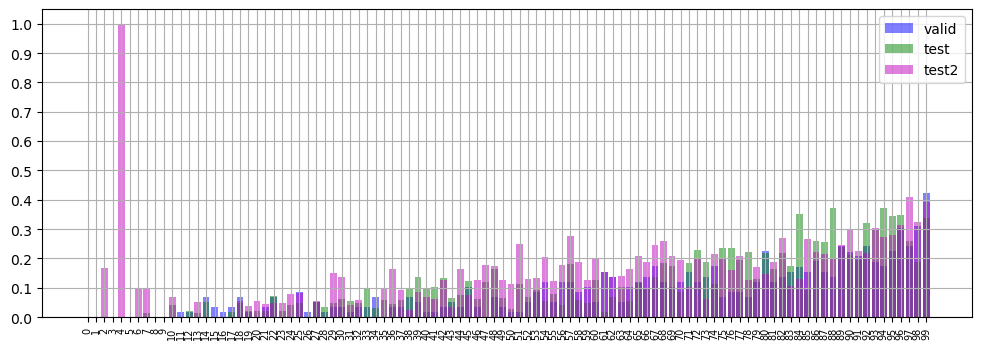

[0.3248 0.3512]


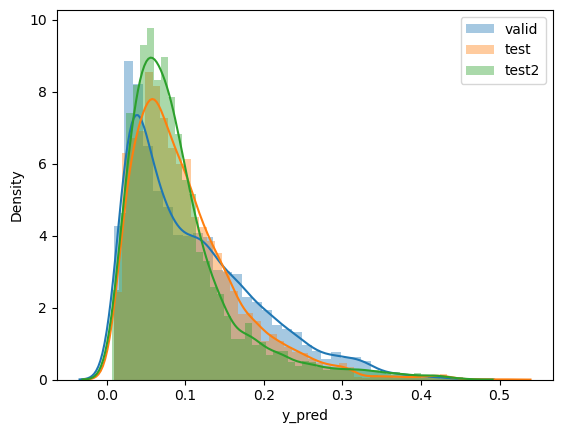

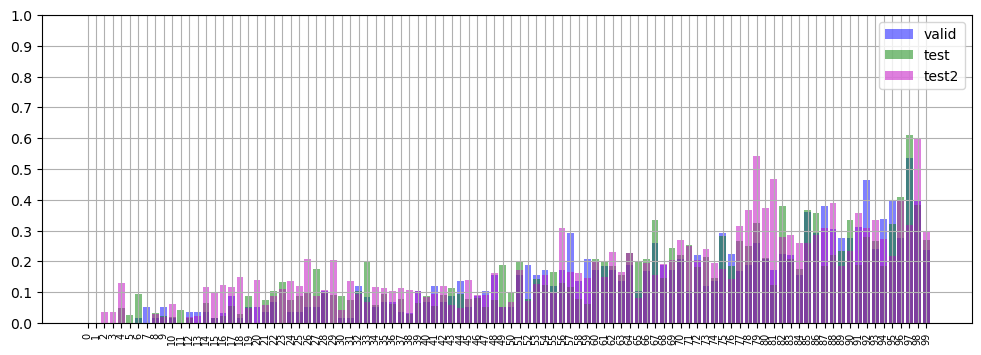

[0.4098 0.4379]


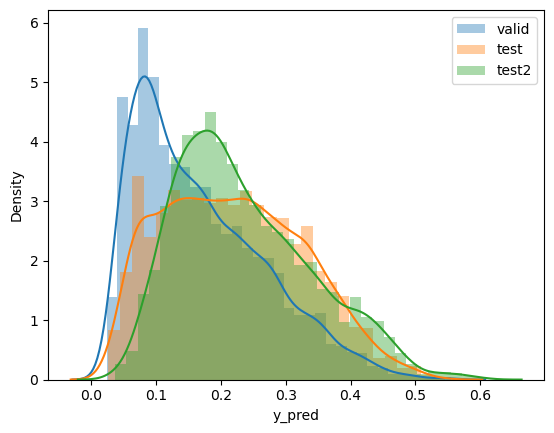

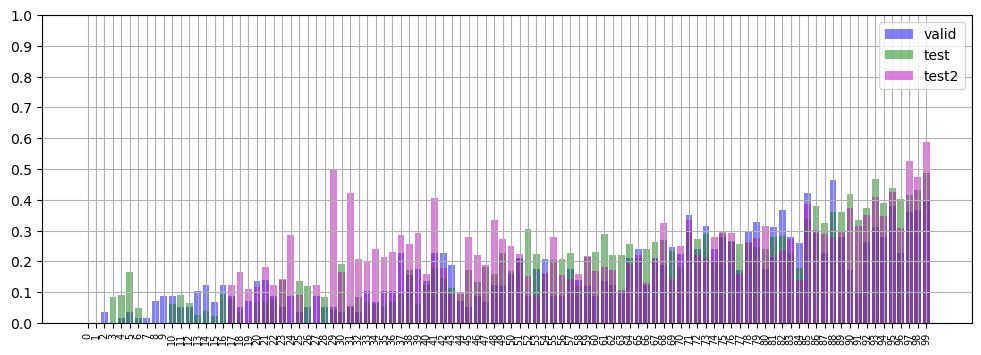

[0.4519 0.4734]


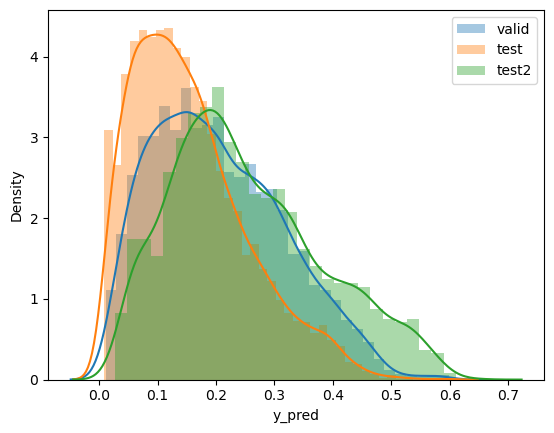

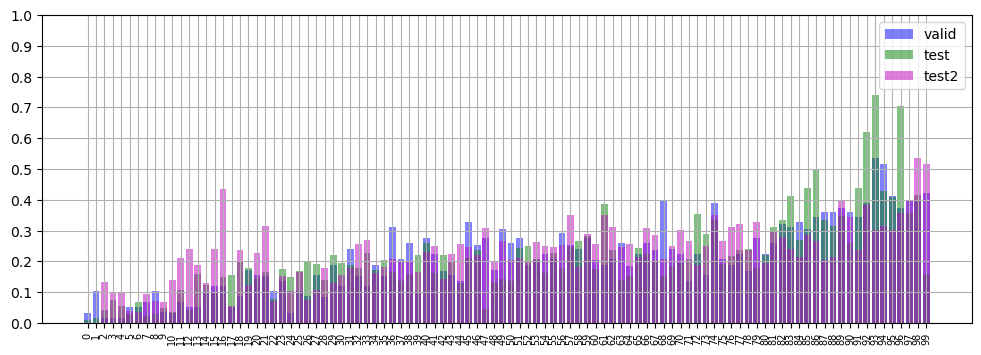

[0.4171 0.4402]


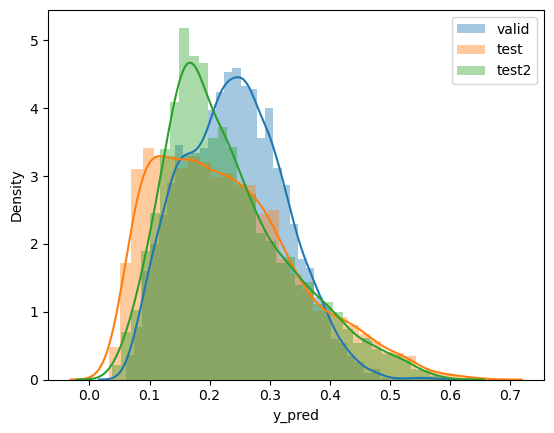

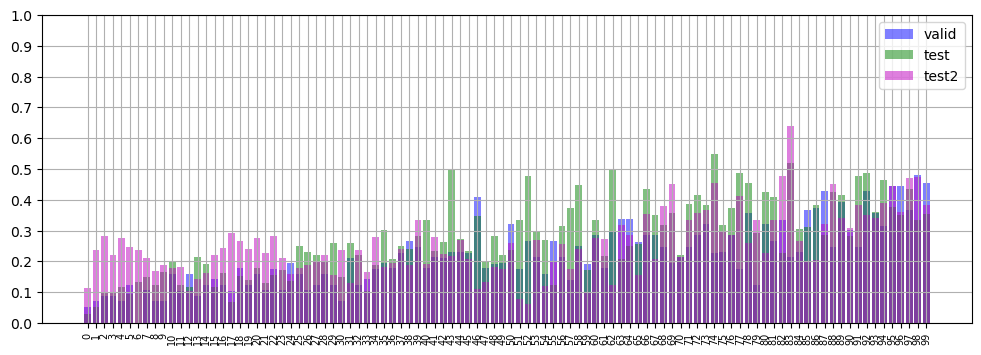

[0.4171 0.4405]


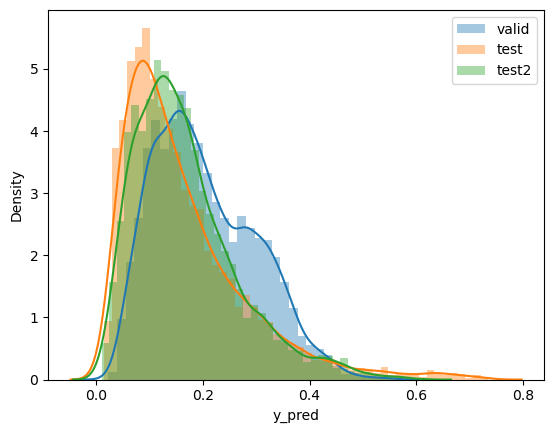

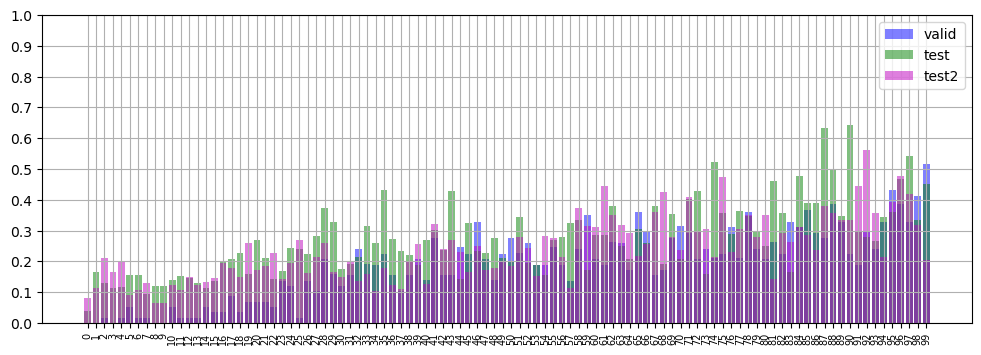

[0.4367 0.4693]


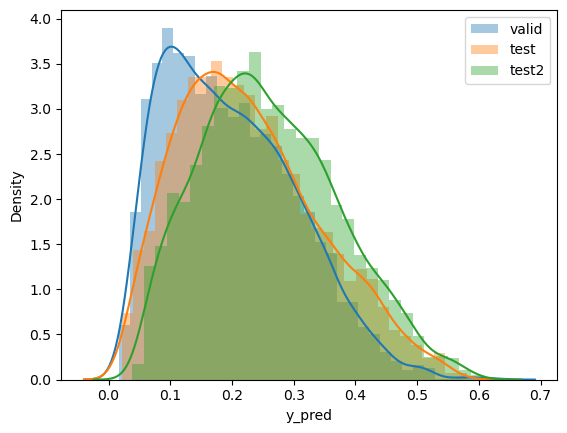

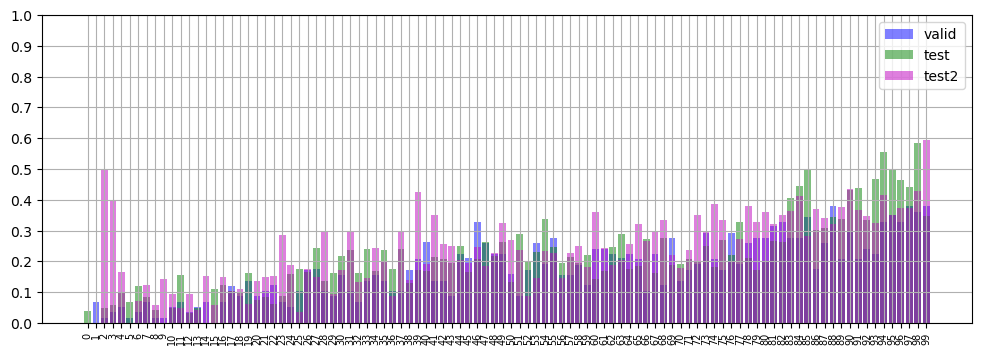

[0.3678 0.389 ]


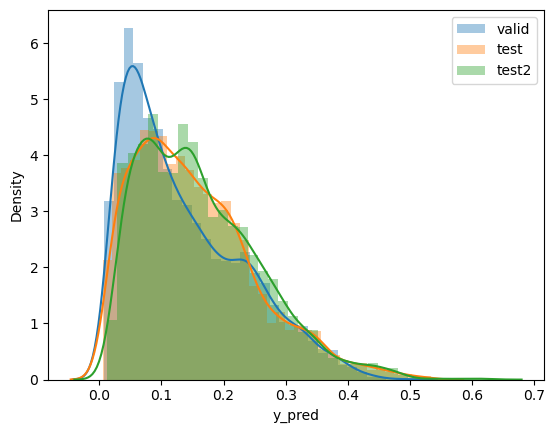

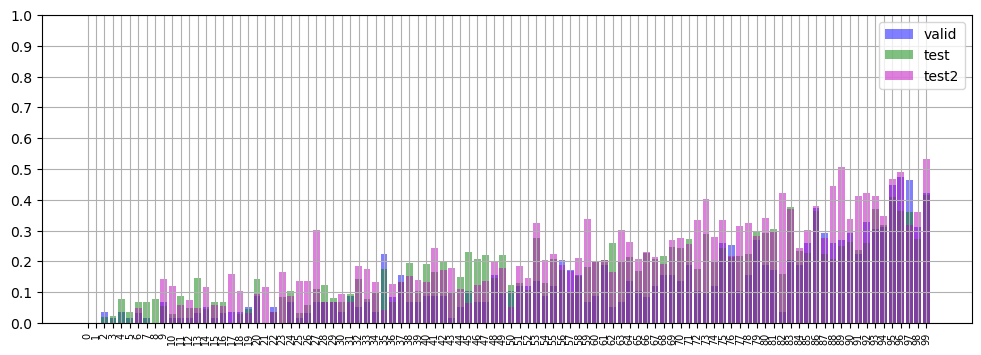

[0.5115 0.547 ]


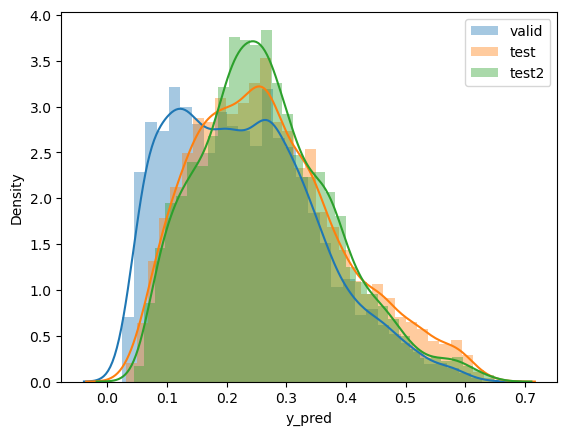

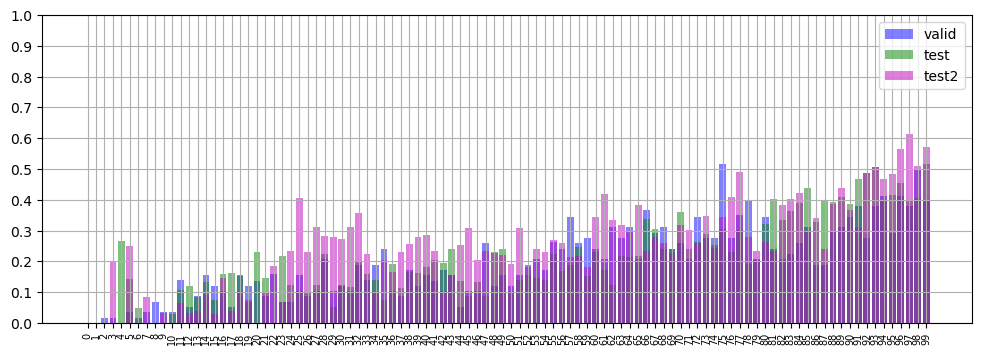

[0.4675 0.525 ]


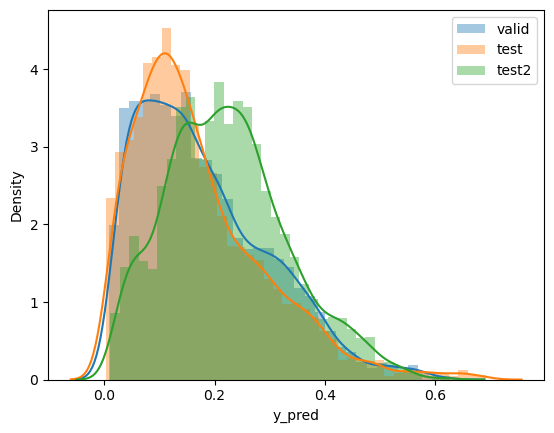

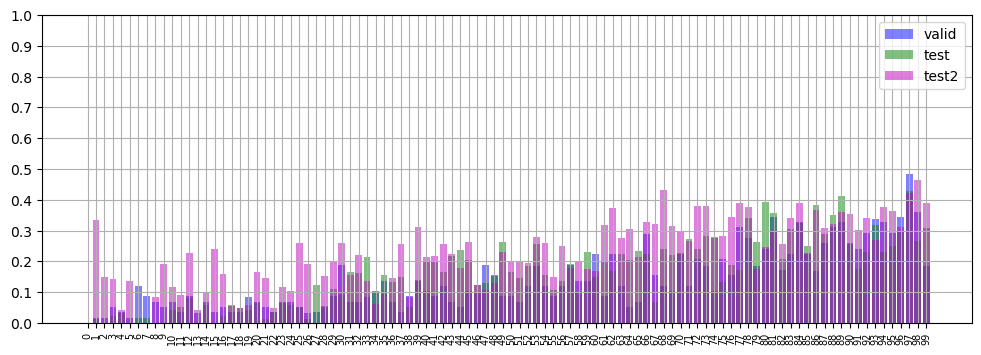

[0.4701 0.5039]


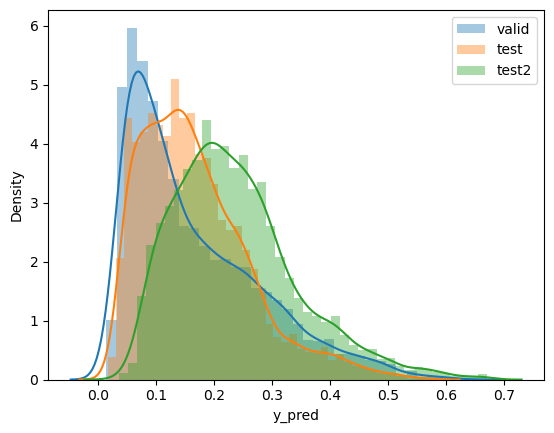

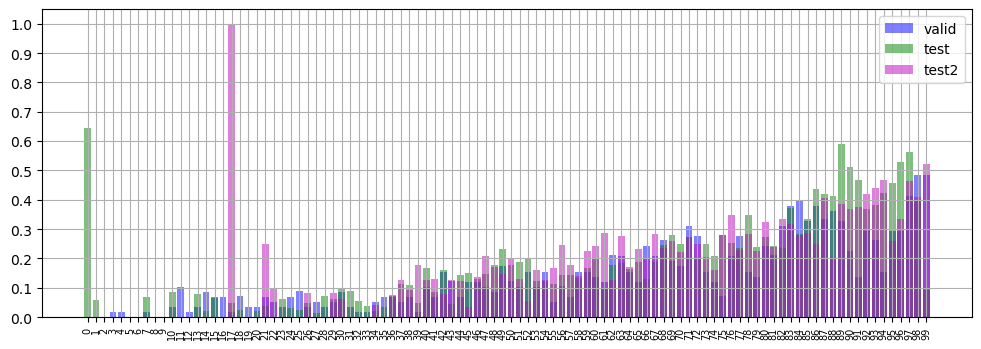

[0.4579 0.49  ]


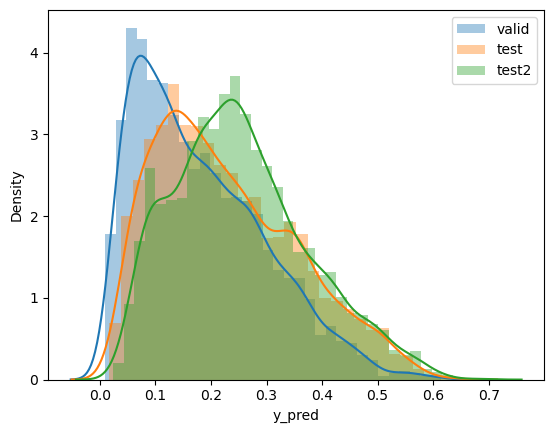

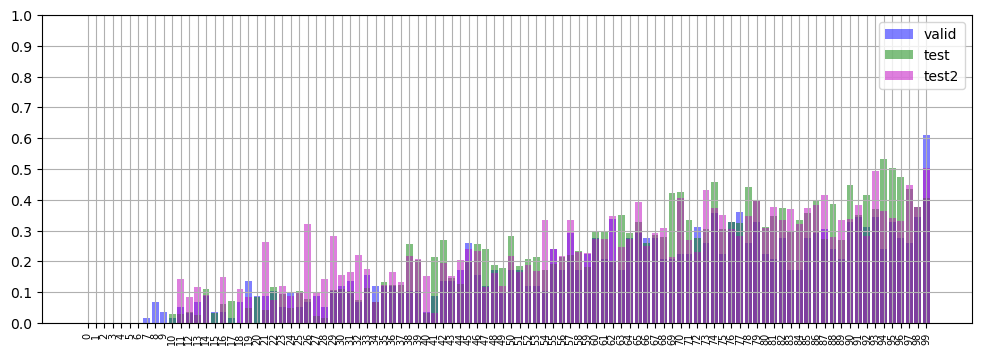

[0.4974 0.5359]


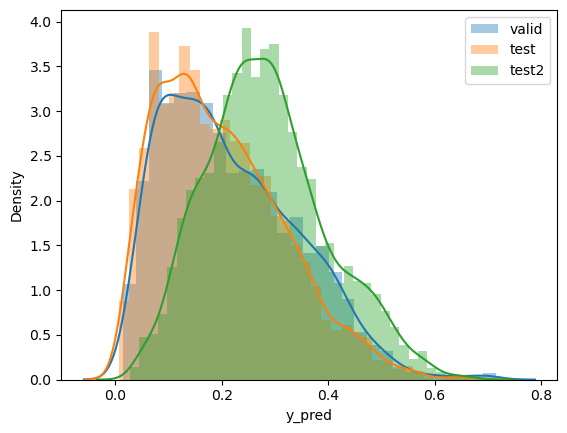

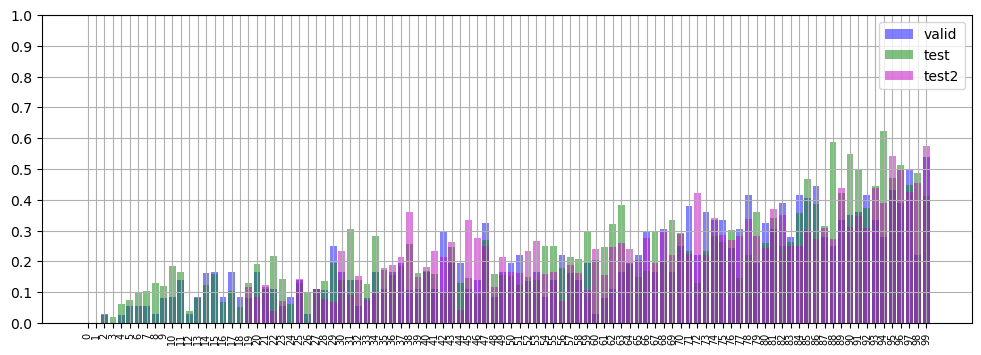

[0.4481 0.4796]


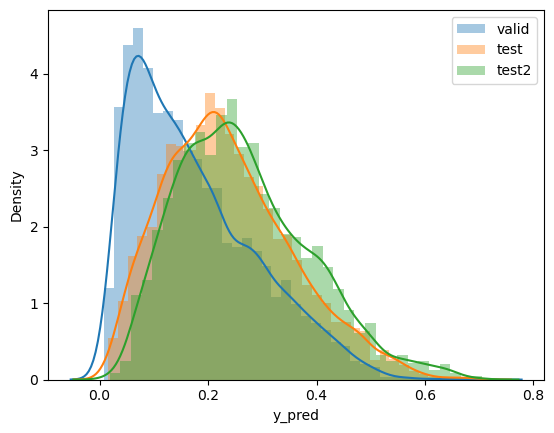

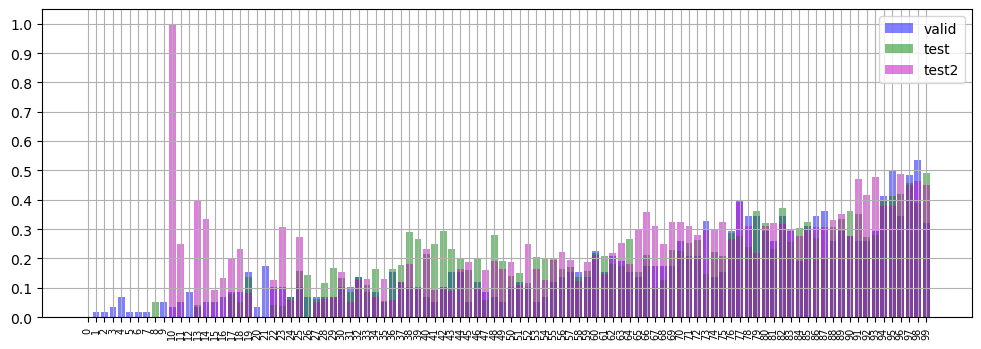

[0.4955 0.5319]


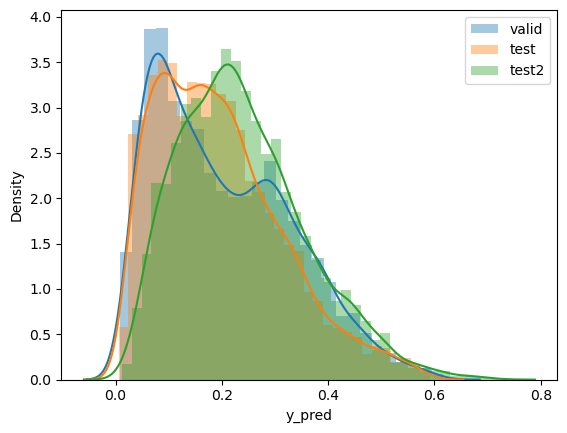

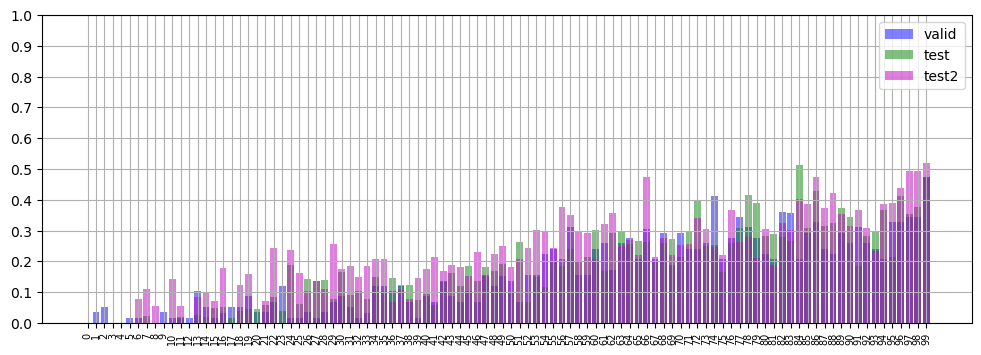

[0.4444 0.4622]


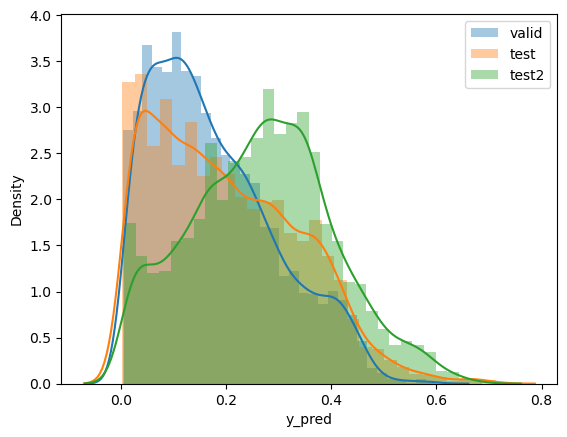

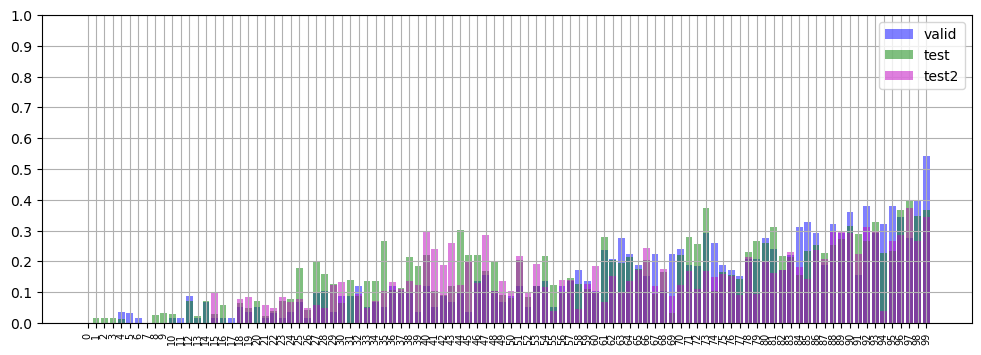

[0.5406 0.5732]


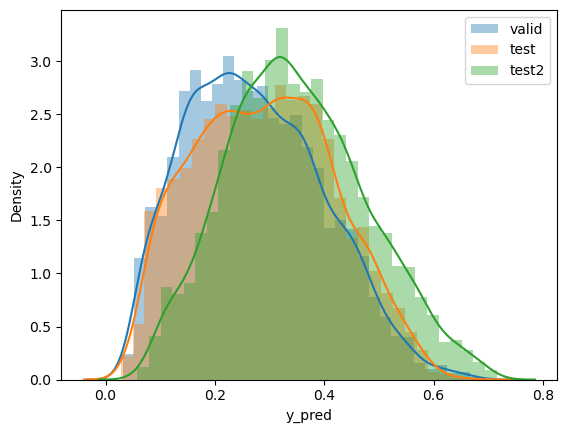

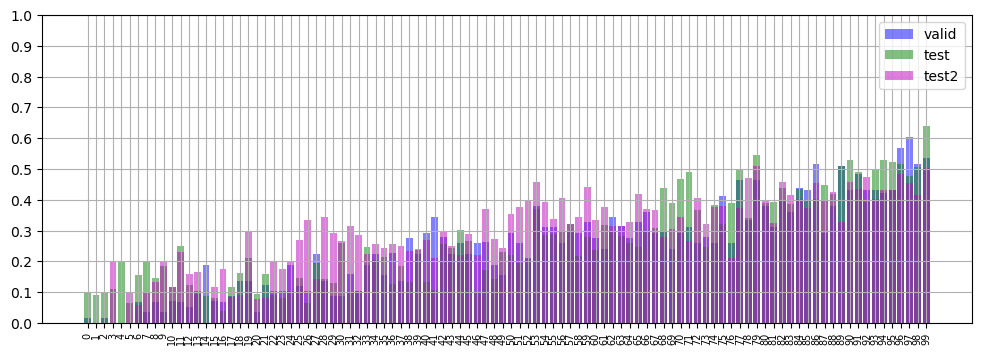

[0.5288 0.5541]


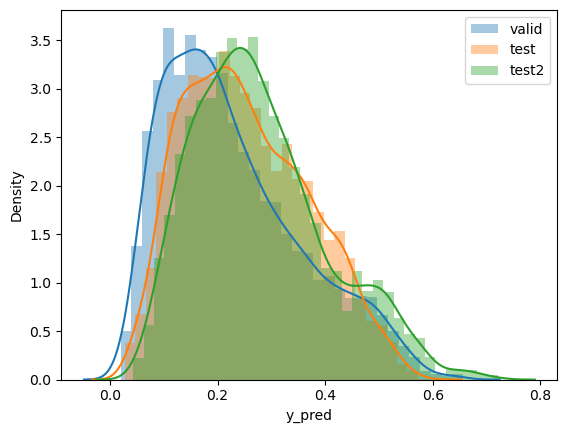

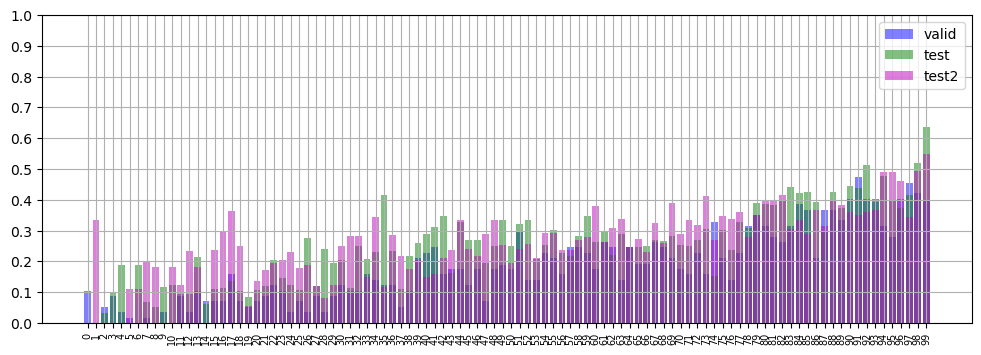

In [143]:
distplot(df, col_target='target',q_count=100)

In [150]:
#есть какие-то зацепки (Алроса, Магнит, СургутНГ)

### таргет24

In [154]:
#distplot(df, col_target='target24',q_count=50)

In [155]:
#Похоже, что искать свой попрог в каждой акции не лучшая идея

### Рассмотрим общий порог для всех акций

In [145]:
def distplot_common_threshold(df, col_target=None, q_count=None):

    mask_valid = df['sample'] == 'valid'
    q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
    
    for ticker in df['ticker'].unique():
        
        mask_valid = df['sample'] == 'valid'
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'
        




        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.cut(df_tk.loc[mask_valid, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_valid, 'bin'] = df_tk.loc[mask_valid, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

        if (df_tk['bin'] == q_count-1).sum() > 0:
            print(ticker)
            print(np.round(np.quantile(df.loc[df['sample'] == 'valid', 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
    

            
            sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
            sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
            sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
            plt.legend()
            plt.show()
        

            
        #print
            plt.figure(figsize=(12,4))
    
            df_tmp = df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)
            
            df_tmp = df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)
            
            df_tmp = df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
            plt.grid(visible=0.0001)
            plt.yticks(np.arange(0, 1.1, 0.1))
            plt.xticks(np.arange(q_count), rotation=90, size=7)
            plt.legend()
            plt.show()

            mask_last_bin = df_tk['bin'] == q_count-1
            print(f'PRECISION: {round(df_tk.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
        
        



        
        

### общий порог, таргет

GAZP
[0.465  0.5036]


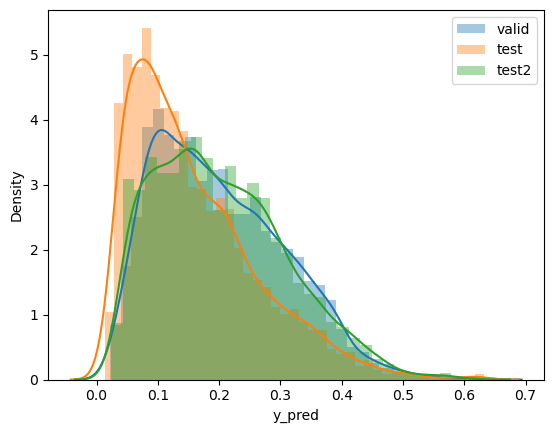

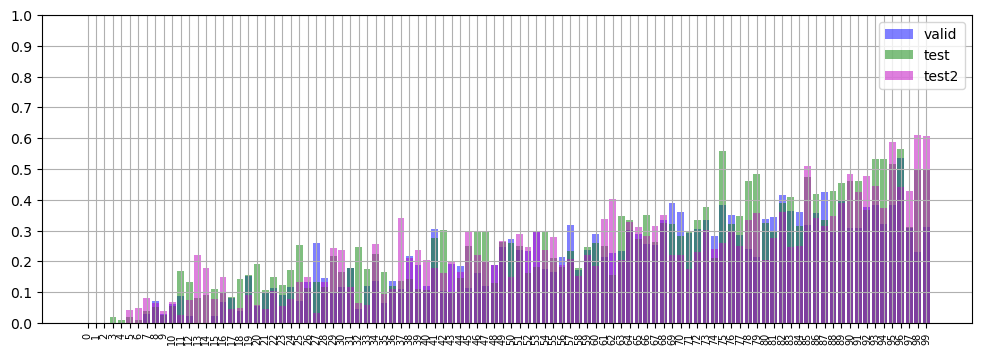

PRECISION: 0.31, 0.5, 0.61
SBER
[0.465  0.5036]


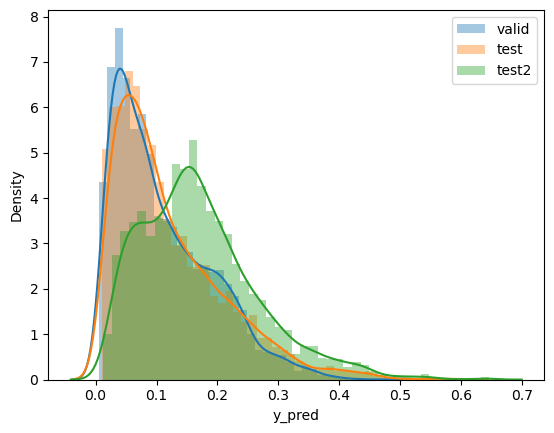

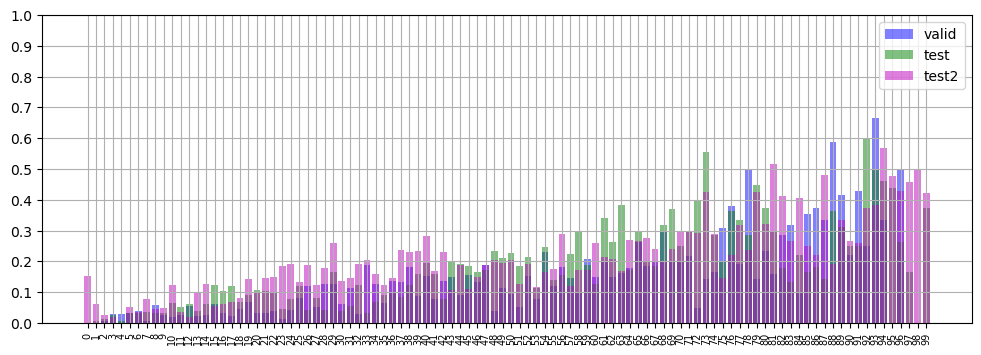

PRECISION: nan, 0.38, 0.42
MGNT
[0.465  0.5036]


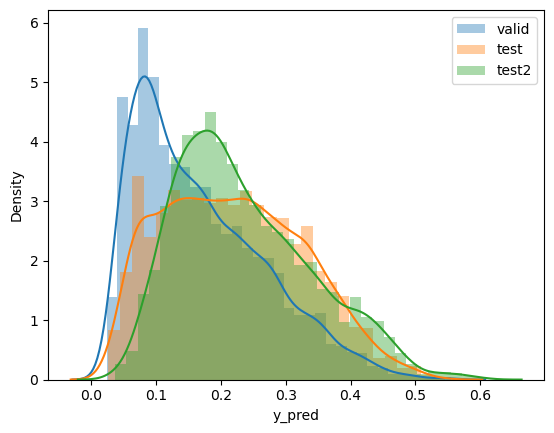

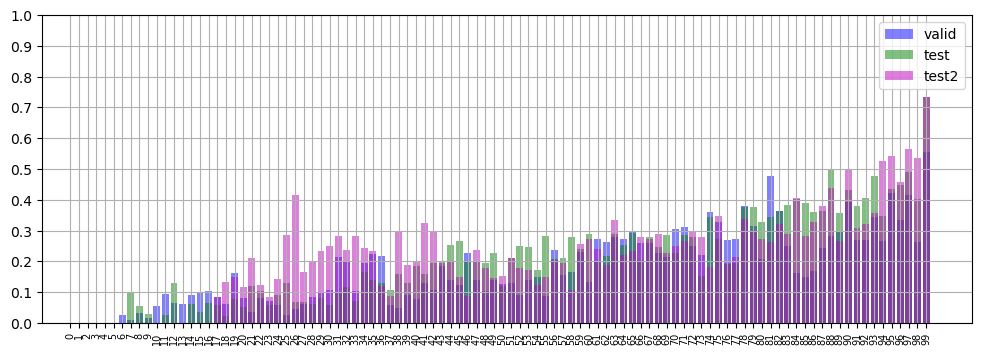

PRECISION: 0.56, 0.73, 0.73
NVTK
[0.465  0.5036]


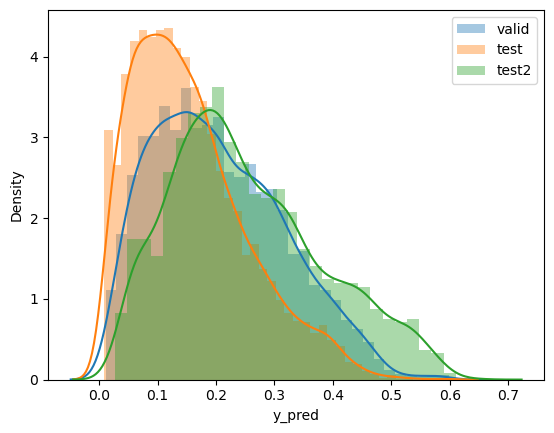

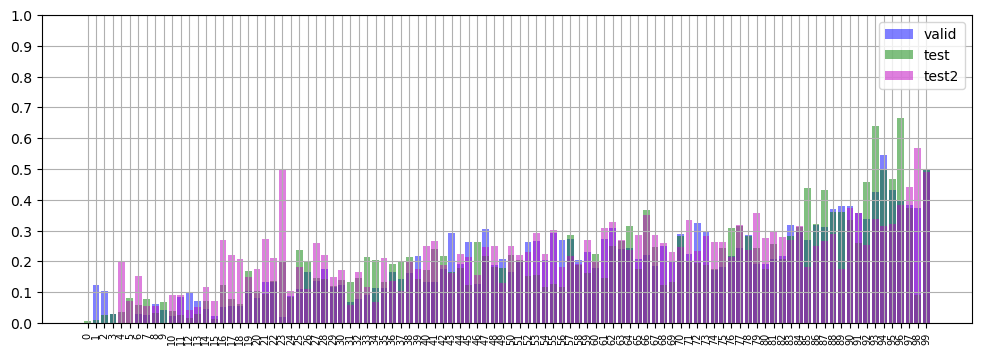

PRECISION: 0.5, 0.5, 0.49
SNGS
[0.465  0.5036]


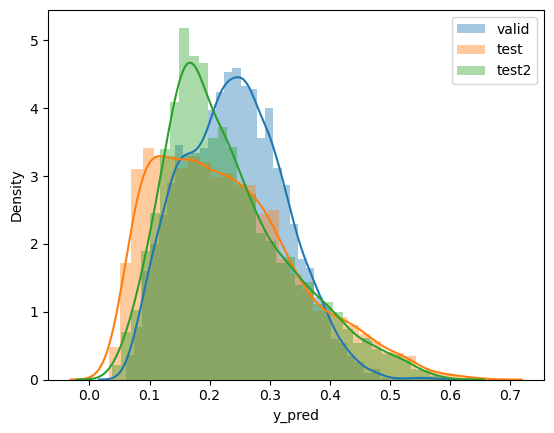

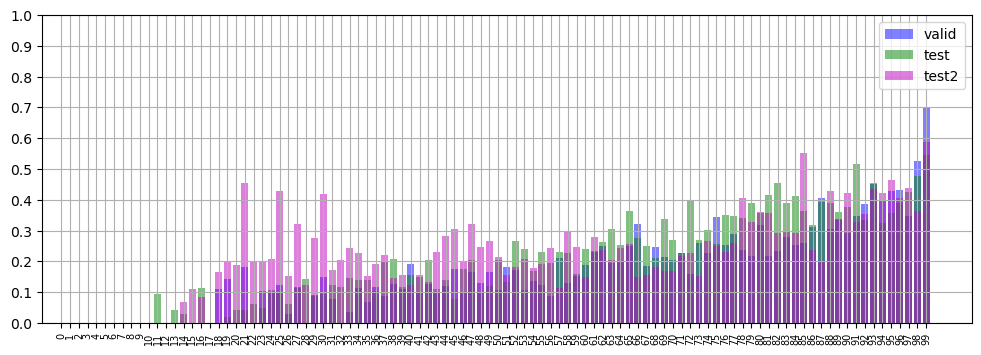

PRECISION: 0.7, 0.54, 0.59
SNGSP
[0.465  0.5036]


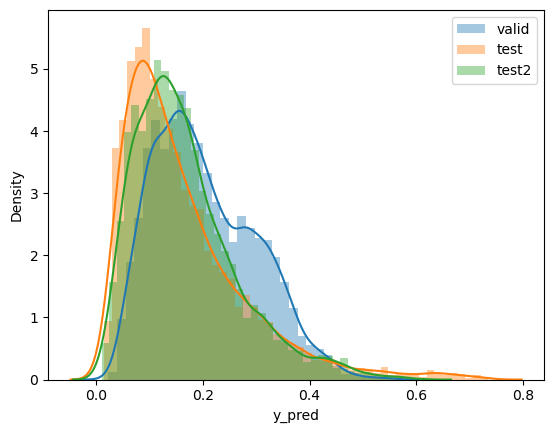

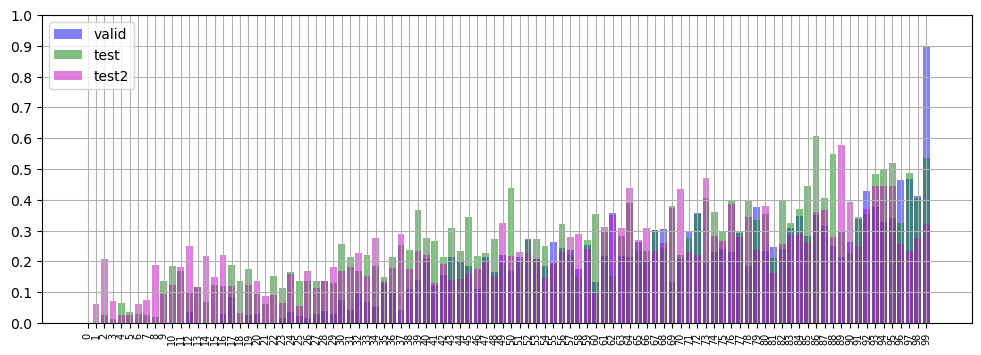

PRECISION: 0.9, 0.54, 0.32
GMKN
[0.465  0.5036]


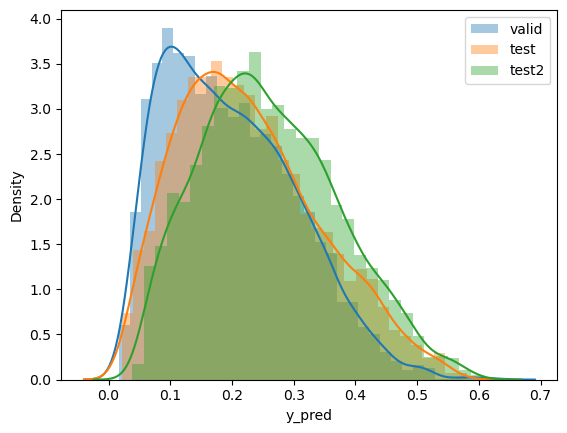

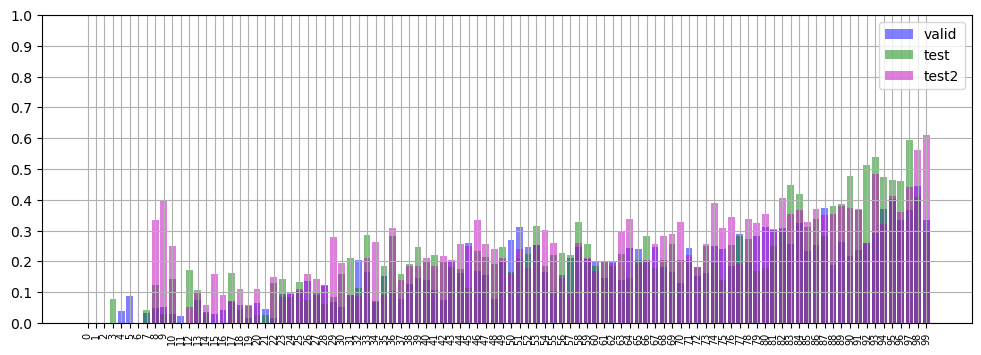

PRECISION: 0.33, 0.3, 0.61
ROSN
[0.465  0.5036]


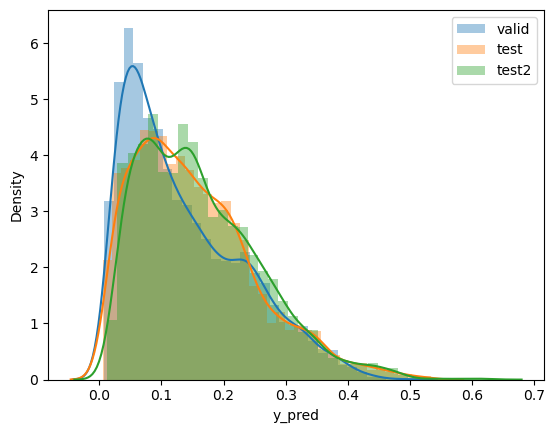

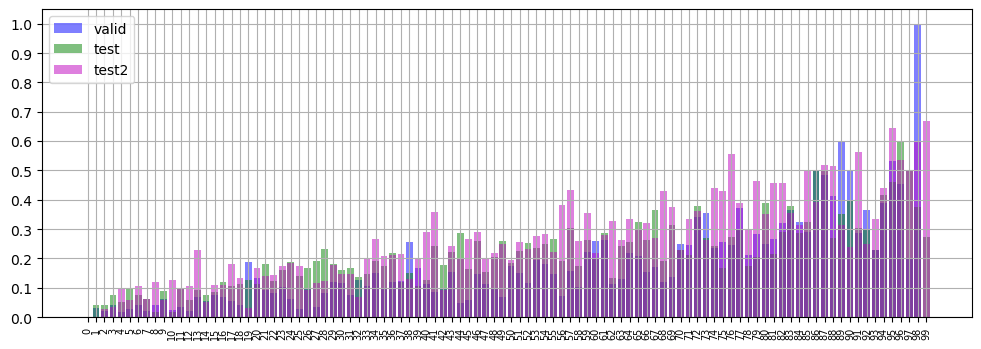

PRECISION: nan, 0.27, 0.67
NLMK
[0.465  0.5036]


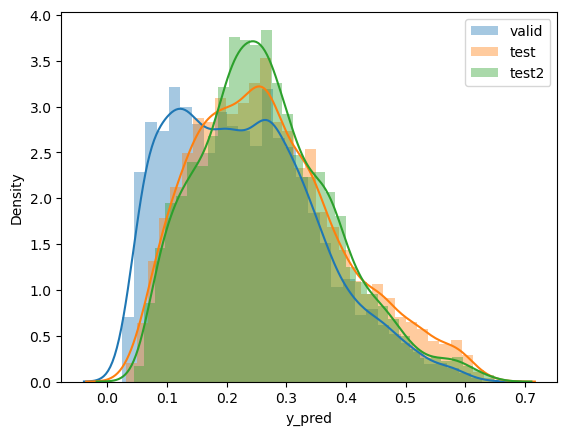

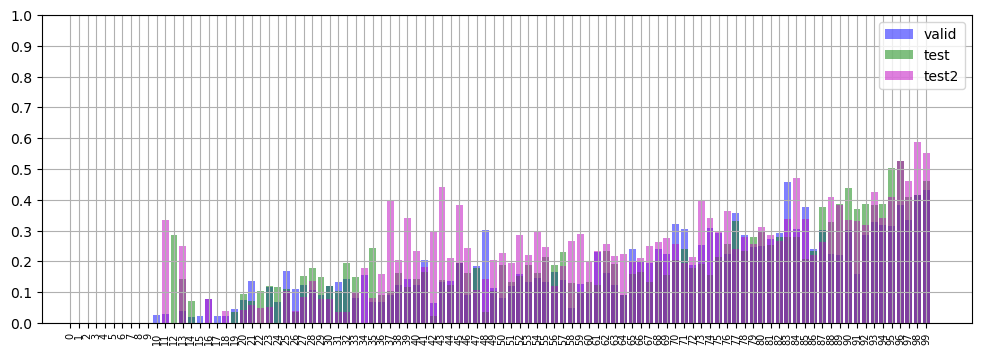

PRECISION: 0.43, 0.46, 0.55
TATN
[0.465  0.5036]


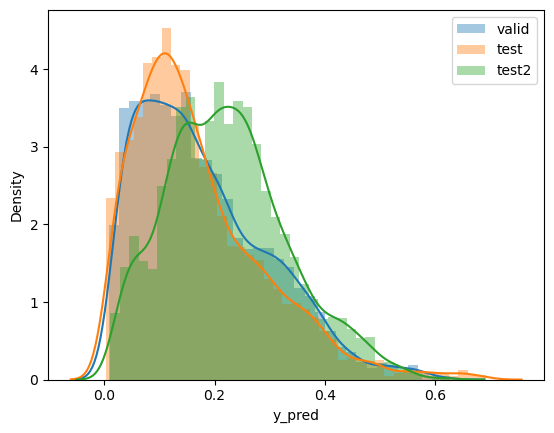

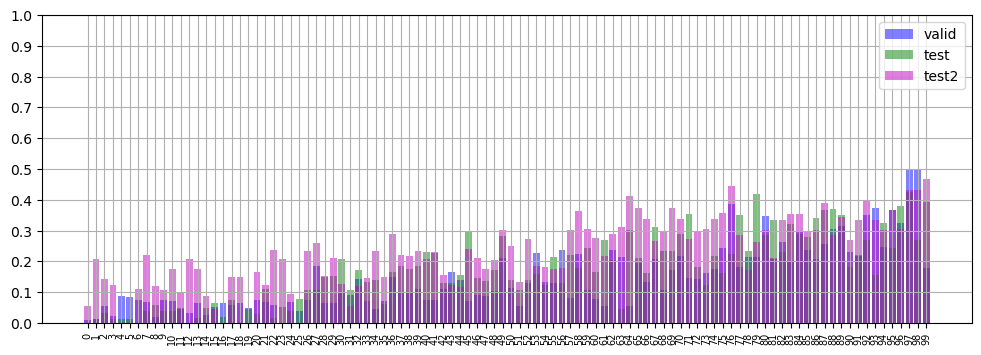

PRECISION: 0.18, 0.39, 0.47
MTSS
[0.465  0.5036]


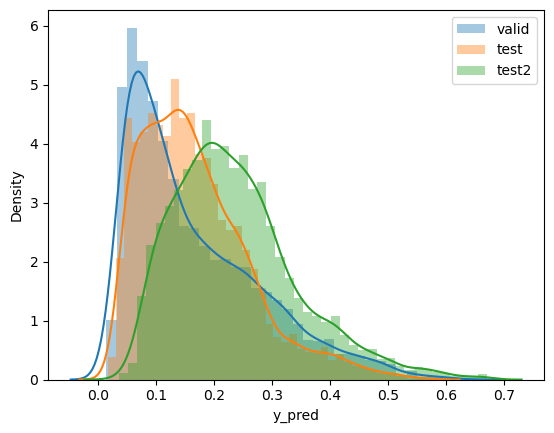

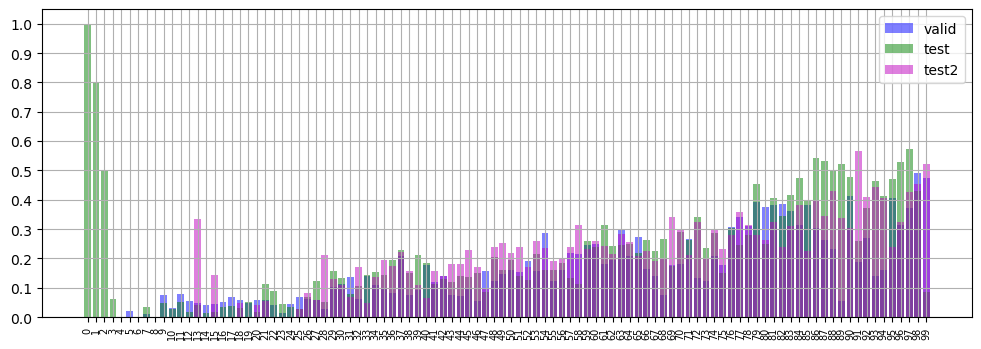

PRECISION: 0.47, 0.09, 0.52
ALRS
[0.465  0.5036]


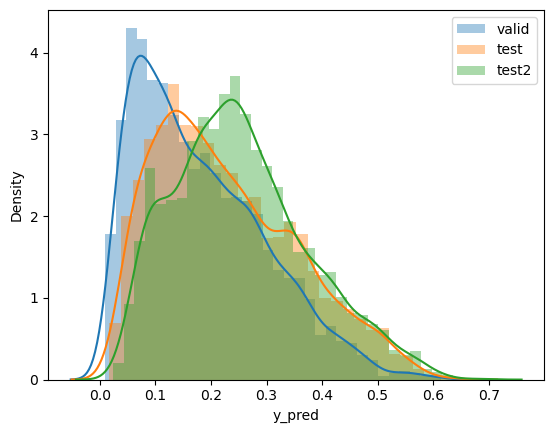

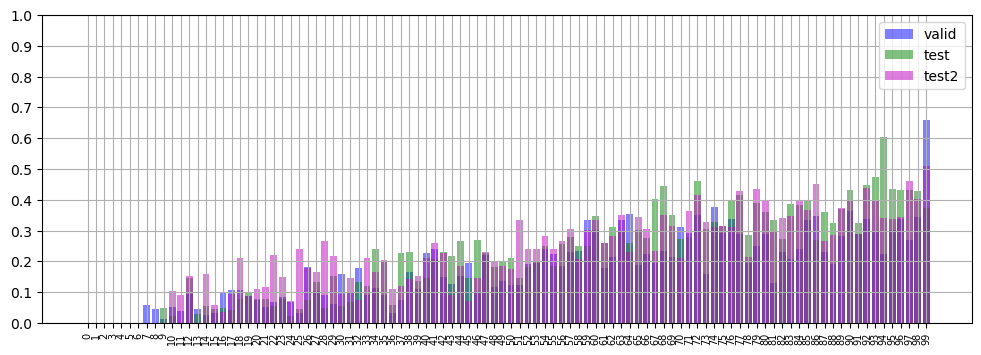

PRECISION: 0.66, 0.38, 0.51
YDEX
[0.465  0.5036]


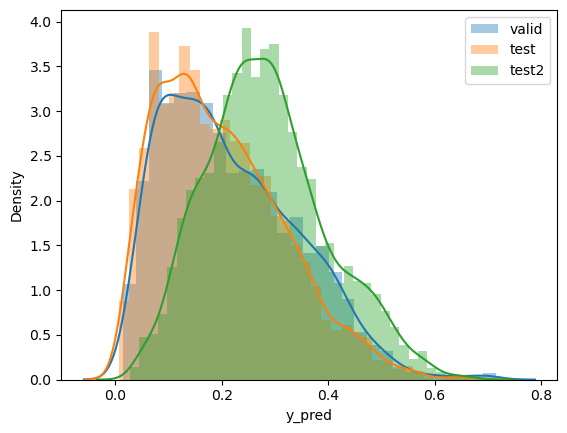

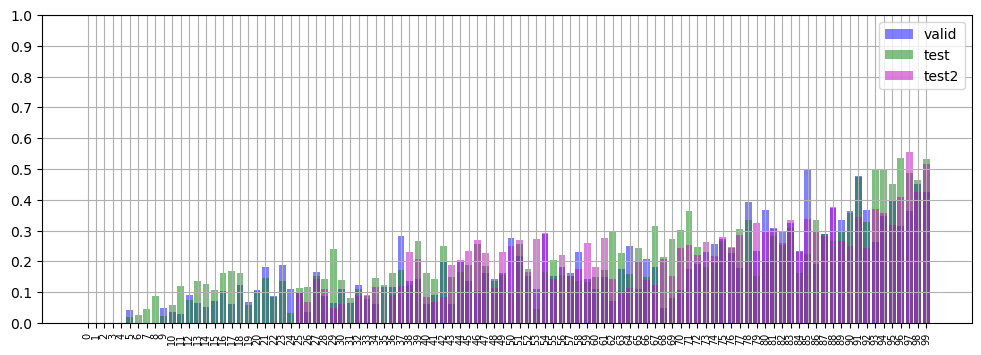

PRECISION: 0.42, 0.53, 0.52
CHMF
[0.465  0.5036]


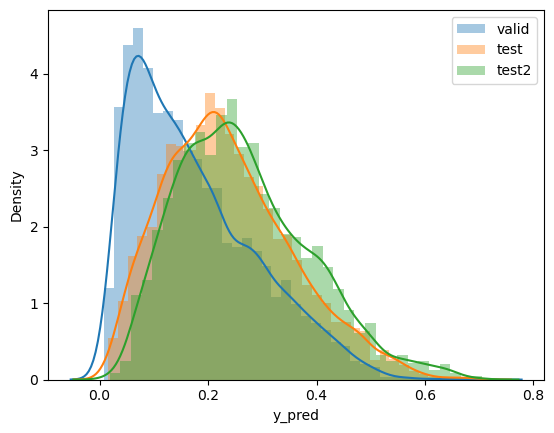

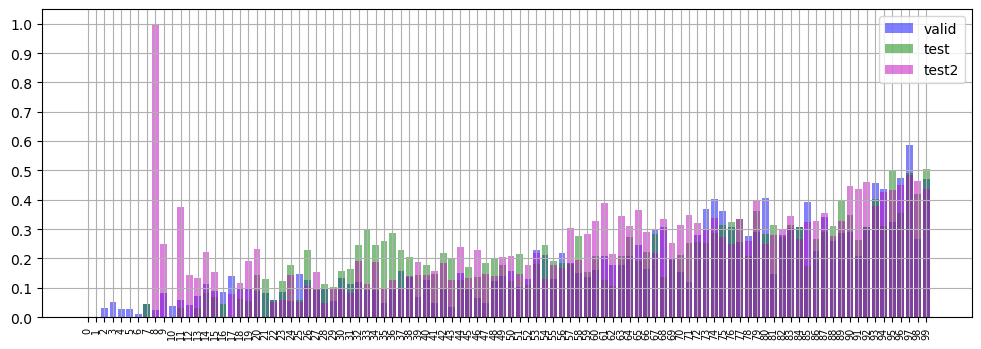

PRECISION: 0.47, 0.5, 0.44
MAGN
[0.465  0.5036]


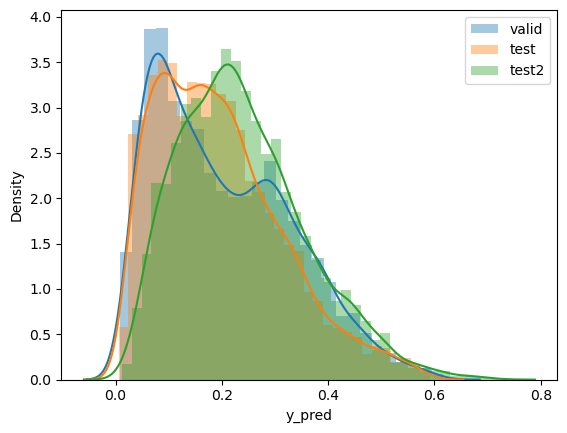

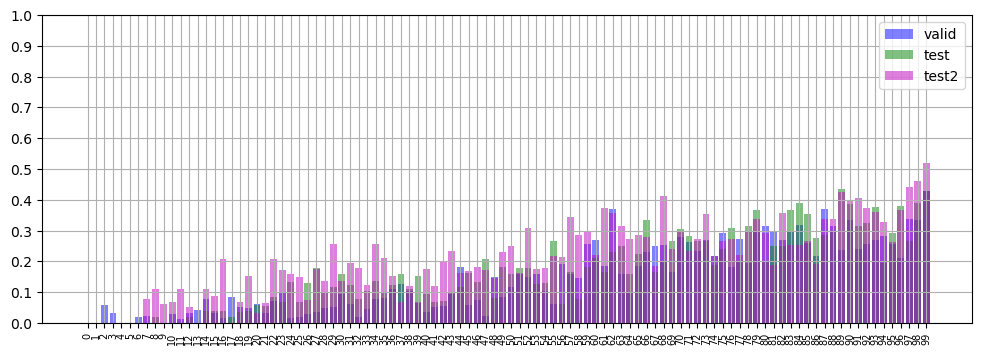

PRECISION: 0.43, 0.43, 0.52
T
[0.465  0.5036]


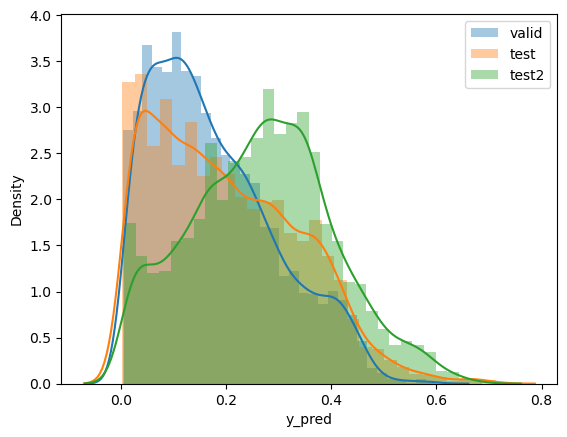

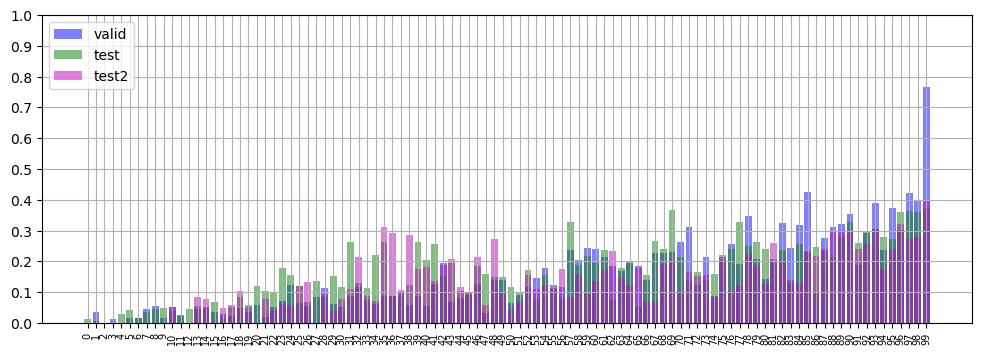

PRECISION: 0.76, 0.37, 0.4
OZON
[0.465  0.5036]


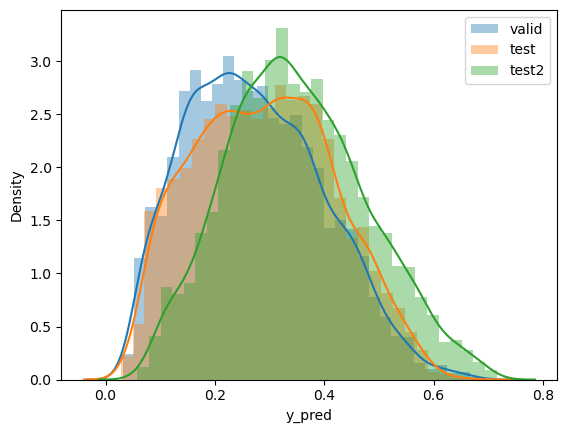

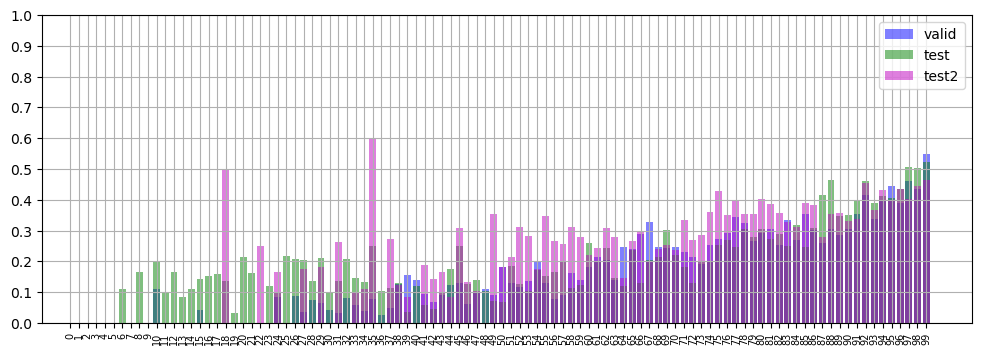

PRECISION: 0.55, 0.52, 0.47
RUAL
[0.465  0.5036]


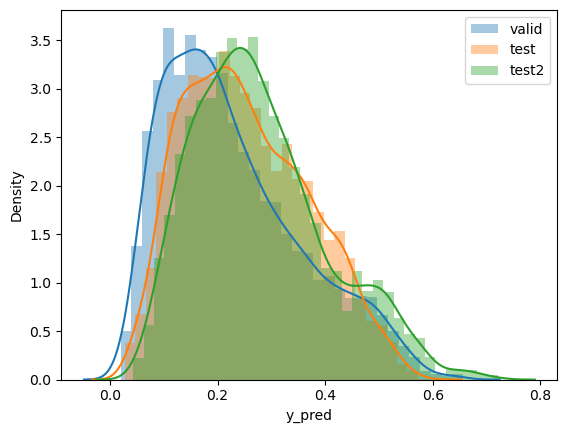

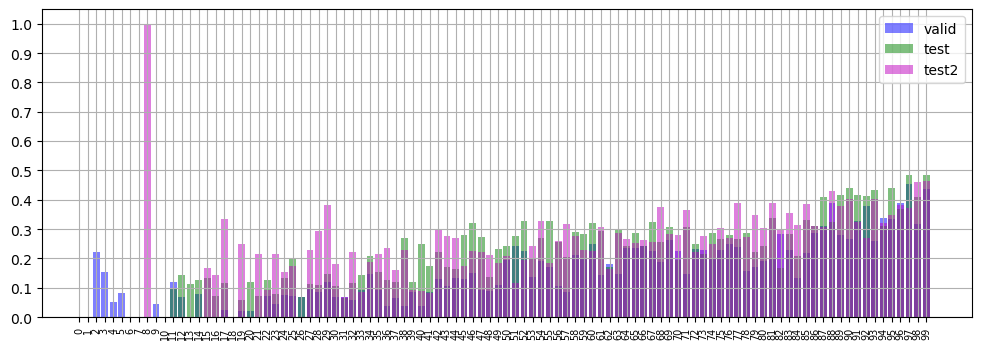

PRECISION: 0.44, 0.49, 0.46


In [150]:
distplot_common_threshold(df, col_target='target',q_count=100)

### общий порог, таргет12

In [169]:
# distplot_common_threshold(df, col_target='target24',q_count=50)

In [170]:
#тут результаты плохие в разрезе акций

# Донастройка

In [152]:
# По сути интересен только 99-перцентиль

In [154]:
#И точек норм, магия какая-то

In [156]:
q=0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshold = {threshold}')

mask = df['y_pred'] > threshold
print((mask_valid&mask).sum(), df.loc[mask_valid&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print((mask_test&mask).sum(),df.loc[mask_test&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print((mask_test2&mask).sum(),df.loc[mask_test2&mask, 'target'].mean())

threshold = 0.5035864776372909
1079 0.4578313253012048
1078 0.4907235621521336
923 0.5308775731310943


In [159]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshold = {threshold}')

mask = df['y_pred'] > threshold
print((mask_valid&mask).sum(), df.loc[mask_valid&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print((mask_test&mask).sum(),df.loc[mask_test&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print((mask_test2&mask).sum(),df.loc[mask_test2&mask, 'target'].mean())

threshold = 0.5035864776372909
1079 0.4578313253012048
1809 0.4626865671641791
2779 0.49010435408420294


[0.465  0.5036]


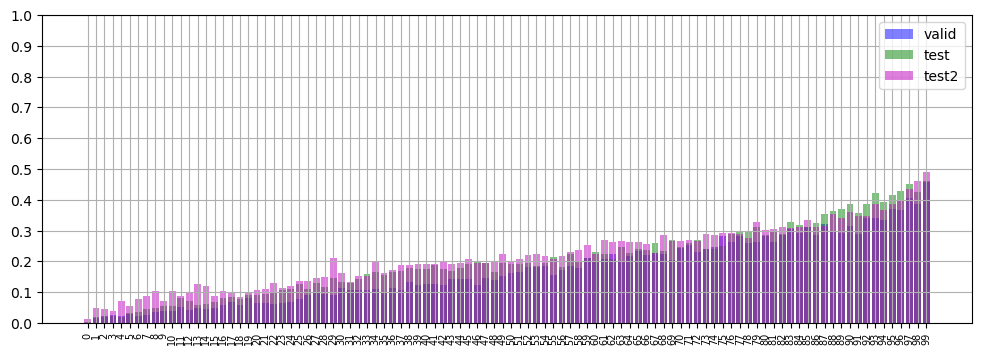

In [162]:
col_target = 'target'
q_count = 100



mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
#df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
#df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
#df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

#print
plt.figure(figsize=(12,4))
df_tmp = df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)

df_tmp = df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)

df_tmp = df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
plt.grid(visible=0.0001)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(q_count), rotation=90, size=7)
plt.legend()
plt.show()


In [164]:
def exp_smoothing(df, col_target, alpha, q=0.99):
    mask = df['sample'].notnull()
    y_pred = np.array(df.loc[mask, 'y_pred']).copy()

    mask_valid = df['sample'] == 'valid'
    mask_test = df['sample'] == 'test'
    mask_test2 = df['sample'] == 'test2'
    
    for i in range(1, y_pred.shape[0]):
        y_pred[i] = (1-alpha)*y_pred[i-1] + alpha*y_pred[i]
    
    df['y_pred_exp'] = None
    df.loc[mask, 'y_pred_exp'] = y_pred


    
    threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=q)
    mask_last_bin = df['y_pred_exp'] > threshold
    
    print(f'ALPHA = {round(alpha,3)}, PRECISION: {round(df.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
    

### таргет

In [173]:
for alpha in np.arange(0.1, 1.1, 0.1):
    exp_smoothing(df, 'target', alpha, q=0.995)

ALPHA = 0.1, PRECISION: 0.43, 0.41, 0.51
ALPHA = 0.2, PRECISION: 0.47, 0.43, 0.51
ALPHA = 0.3, PRECISION: 0.47, 0.44, 0.5
ALPHA = 0.4, PRECISION: 0.47, 0.46, 0.5
ALPHA = 0.5, PRECISION: 0.47, 0.47, 0.5
ALPHA = 0.6, PRECISION: 0.47, 0.47, 0.5
ALPHA = 0.7, PRECISION: 0.48, 0.48, 0.5
ALPHA = 0.8, PRECISION: 0.48, 0.49, 0.5
ALPHA = 0.9, PRECISION: 0.48, 0.5, 0.51
ALPHA = 1.0, PRECISION: 0.48, 0.5, 0.51


In [209]:
# for alpha in np.arange(0.01, 1, 0.01):
#     exp_smoothing(df, 'target', alpha, q=0.99)

In [211]:
# for alpha in np.arange(0.005, 0.05, 0.005):
#     exp_smoothing(df, 'target', alpha, q=0.995)

In [213]:
# for alpha in np.arange(0.001, 0.011, 0.001):
#     exp_smoothing(df, 'target', alpha, q=0.995)

In [215]:
#ALPHA = 0.005, PRECISION: 0.43, 0.42, 0.56

In [219]:
#И сколько их в день интересно? И на каких акциях?

In [222]:
#Разные варианты

In [224]:
exp_smoothing(df, 'target', 1, q=0.98)
#ALPHA = 1, PRECISION: 0.52, 0.51, 0.51

ALPHA = 1, PRECISION: 0.52, 0.51, 0.5


In [226]:
exp_smoothing(df, 'target', 1, q=0.99)
#ALPHA = 1, PRECISION: 0.55, 0.53, 0.54

ALPHA = 1, PRECISION: 0.55, 0.53, 0.52


In [228]:
exp_smoothing(df, 'target', 1, q=0.995)
#ALPHA = 1, PRECISION: 0.62, 0.59, 0.63

ALPHA = 1, PRECISION: 0.62, 0.59, 0.61


In [182]:
mask_valid = df['sample'] == 'valid'
threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=0.99)
threshold

0.5035864776372909

In [185]:
mask_threshold = df['y_pred_exp']  > threshold

mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_threshold].shape[0], df.loc[mask_test&mask_threshold].shape[0], df.loc[mask_test2&mask_threshold].shape[0]

(1079, 1809, 2779)

In [187]:
df.loc[mask_valid&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_threshold, 'time'].dt.date.nunique()

(26, 25, 28)

In [189]:
df.loc[mask_valid&mask_threshold, 'ticker'].unique(), df.loc[mask_test&mask_threshold, 'ticker'].unique(), df.loc[mask_test2&mask_threshold, 'ticker'].unique()

(array(['GAZP', 'MGNT', 'NVTK', 'SNGS', 'SNGSP', 'GMKN', 'NLMK', 'TATN',
        'MTSS', 'ALRS', 'YDEX', 'CHMF', 'MAGN', 'T', 'OZON', 'RUAL'],
       dtype=object),
 array(['GAZP', 'SBER', 'MGNT', 'NVTK', 'SNGS', 'SNGSP', 'GMKN', 'ROSN',
        'NLMK', 'TATN', 'MTSS', 'ALRS', 'YDEX', 'CHMF', 'MAGN', 'T',
        'OZON', 'RUAL'], dtype=object),
 array(['GAZP', 'SBER', 'MGNT', 'NVTK', 'SNGS', 'SNGSP', 'GMKN', 'ROSN',
        'NLMK', 'TATN', 'MTSS', 'ALRS', 'YDEX', 'CHMF', 'MAGN', 'T',
        'OZON', 'RUAL'], dtype=object))

In [240]:
#SGNS, MAGN, RUAL

In [242]:
#Разъеб!?.

### Качество во времени

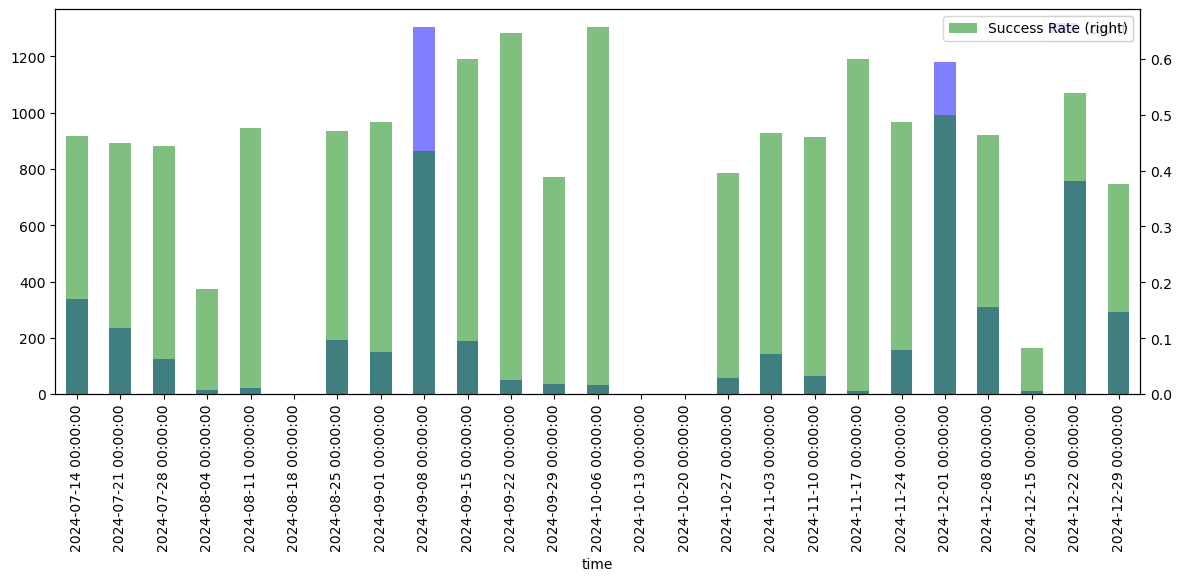

In [191]:
#distibution in timed

q = 0.99
freq='W'

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask_last_bin = df['y_pred'] > threshold

mask_data = mask_valid|mask_test|mask_test2
plt.figure(figsize=(14, 5))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()

In [193]:
df.loc[mask_test2&mask_last_bin, ['time', 'close','ticker', 'target', 'delta_time']].iloc[-10:]

time      close ticker  target      delta_time
307548 2024-12-23 11:55:00  33.400002   RUAL       0 0 days 00:06:00
307552 2024-12-23 12:15:00  33.389999   RUAL       1 0 days 00:11:00
307556 2024-12-23 12:35:00  33.500000   RUAL       1 0 days 00:08:00
307558 2024-12-23 12:45:00  33.799999   RUAL       0 0 days 00:10:00
307559 2024-12-23 12:50:00  33.730000   RUAL       0 0 days 00:09:00
307560 2024-12-23 12:55:00  33.610001   RUAL       0 0 days 00:15:00
307574 2024-12-23 14:05:00  33.570000   RUAL       1 0 days 00:11:00
307575 2024-12-23 14:10:00  33.590000   RUAL       0 0 days 00:33:00
307577 2024-12-23 14:20:00  33.645000   RUAL       0 0 days 00:23:00
307578 2024-12-23 14:25:00  33.599998   RUAL       0 0 days 00:18:00

### Качество при 2-3 сигнала подряд за несколько часов

In [199]:
def precision_repeat_signal(df, col_target=None, signals=None, window=None, q=None):

    mask_valid = df['sample'] == 'valid'
    mask_test = df['sample'] == 'test'
    mask_test2 = df['sample'] == 'test2'


    threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
    mask = df['sample'].notnull()
    y_bin = np.array(df.loc[mask, 'y_pred'] > threshold).astype(int).copy()
    
    y_signals_window = np.zeros(y_bin.shape[0])
    for i in range(window-1, y_bin.shape[0]):
        y_signals_window[i] = y_bin[i-window+1:i+1].sum()
    
    df['y_signals_window'] = None
    df.loc[mask, 'y_signals_window'] = y_signals_window

    mask_signals = np.array(df['y_signals_window'] >= signals)
    
    print(f'SIGNALS = {signals}, WINDOW = {window}, PRECISION: {round(df.loc[mask_valid&mask_signals, col_target].mean(), 2)}, {round(df.loc[mask_test&mask_signals, col_target].mean(), 2)}, {round(df.loc[mask_test2&mask_signals, col_target].mean(), 2)}')
    

In [211]:
#а если порог ослабить

signals_s = [2,3]
windows = [2,3,4,5]
for window in windows:
    for signals in signals_s:
        if signals <= window:
            precision_repeat_signal(df, col_target='target', signals=signals, window=window, q=0.99)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.47, 0.46, 0.49
SIGNALS = 2, WINDOW = 3, PRECISION: 0.45, 0.45, 0.49
SIGNALS = 3, WINDOW = 3, PRECISION: 0.47, 0.45, 0.49
SIGNALS = 2, WINDOW = 4, PRECISION: 0.45, 0.44, 0.49
SIGNALS = 3, WINDOW = 4, PRECISION: 0.46, 0.45, 0.48
SIGNALS = 2, WINDOW = 5, PRECISION: 0.45, 0.44, 0.49
SIGNALS = 3, WINDOW = 5, PRECISION: 0.45, 0.44, 0.48


##### (2, 2)

In [215]:
precision_repeat_signal(df, col_target='target', signals=2, window=2, q=0.99)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.47, 0.46, 0.49


In [217]:
mask_signal = df['y_signals_window'] >= 2

mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_signal].shape[0], df.loc[mask_test&mask_signal].shape[0], df.loc[mask_test2&mask_signal].shape[0]

(815, 1422, 2314)

In [219]:
#кол-во разных дней
df.loc[mask_valid&mask_signal, 'time'].dt.date.nunique(), df.loc[mask_test&mask_signal, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_signal, 'time'].dt.date.nunique()

(20, 21, 25)

In [221]:
#кол-во разных тикеров
df.loc[mask_valid&mask_signal, 'ticker'].unique(), df.loc[mask_test&mask_signal, 'ticker'].unique(), df.loc[mask_test2&mask_signal, 'ticker'].unique()

(array(['GAZP', 'MGNT', 'NVTK', 'SNGS', 'SNGSP', 'GMKN', 'NLMK', 'TATN',
        'MTSS', 'ALRS', 'YDEX', 'CHMF', 'MAGN', 'T', 'OZON', 'RUAL'],
       dtype=object),
 array(['GAZP', 'SBER', 'MGNT', 'NVTK', 'SNGS', 'SNGSP', 'GMKN', 'ROSN',
        'NLMK', 'TATN', 'MTSS', 'ALRS', 'YDEX', 'CHMF', 'MAGN', 'T',
        'OZON', 'RUAL'], dtype=object),
 array(['GAZP', 'SBER', 'MGNT', 'NVTK', 'SNGS', 'SNGSP', 'GMKN', 'ROSN',
        'NLMK', 'TATN', 'MTSS', 'ALRS', 'YDEX', 'CHMF', 'MAGN', 'T',
        'OZON', 'RUAL'], dtype=object))

In [223]:
df.loc[mask_valid&mask_signal].groupby('ticker').y_pred.count(), df.loc[mask_test&mask_signal].groupby('ticker').y_pred.count(), df.loc[mask_test2&mask_signal].groupby('ticker').y_pred.count()


(ticker
 ALRS      35
 CHMF      21
 GAZP      26
 GMKN      21
 MAGN      81
 MGNT       5
 MTSS      47
 NLMK     102
 NVTK      22
 OZON     174
 RUAL     140
 SNGS       7
 SNGSP      6
 T         12
 TATN      71
 YDEX      45
 Name: y_pred, dtype: int64,
 ticker
 ALRS     116
 CHMF     115
 GAZP      29
 GMKN      53
 MAGN      67
 MGNT       8
 MTSS      17
 NLMK     267
 NVTK       6
 OZON     231
 ROSN       6
 RUAL      63
 SBER       7
 SNGS      95
 SNGSP    111
 T         94
 TATN      82
 YDEX      55
 Name: y_pred, dtype: int64,
 ticker
 ALRS     137
 CHMF     162
 GAZP      28
 GMKN      71
 MAGN     101
 MGNT      38
 MTSS      97
 NLMK     132
 NVTK     202
 OZON     554
 ROSN       8
 RUAL     257
 SBER      22
 SNGS      58
 SNGSP     21
 T        211
 TATN      43
 YDEX     172
 Name: y_pred, dtype: int64)

### (2, 2)

SIGNALS = 2, WINDOW = 2, PRECISION: 0.47, 0.46, 0.49


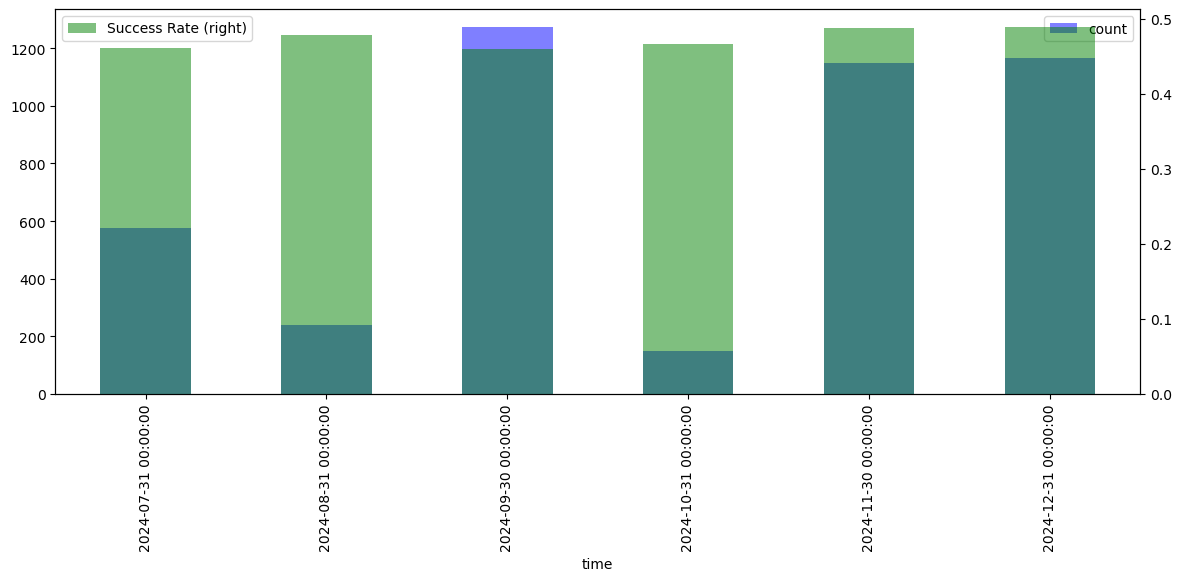

In [226]:
#distibution in timed

freq='ME'

precision_repeat_signal(df, col_target='target', signals=2, window=2, q=0.99)
mask_signal = df['y_signals_window'] >= 2

mask_data = mask_valid|mask_test|mask_test2

plt.figure(figsize=(14, 5))
df.loc[mask_data&mask_signal, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_signal, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()

### таргет (доп для моделей <1 дня)

In [148]:
# for alpha in np.arange(0.1, 1.1, 0.1):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [150]:
# for alpha in np.arange(0.01, 0.11, 0.01):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [152]:
# for alpha in np.arange(0.001, 0.011, 0.001):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [ ]:
#ALPHA = 0.005, PRECISION: 0.53, 0.55, 0.58